In [1]:
import matplotlib.image as mpimg
import numpy as np
import cv2
import pickle
from skimage.feature import hog
import matplotlib.pyplot as plt
import glob
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from scipy.ndimage.measurements import label

# NOTE: the next import is only valid for scikit-learn version <= 0.17
#from sklearn.cross_validation import train_test_split
# for scikit-learn >= 0.18 use:
from sklearn.model_selection import train_test_split




In [100]:
def convert_color(img, conv='RGB2YCrCb'):
    if conv == 'RGB2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    if conv == 'BGR2YCrCb':
        return cv2.cvtColor(img, cv2.COLOR_BGR2YCrCb)
    if conv == 'RGB2LUV':
        return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)

# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=False):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=True, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=True, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features


# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features(imgs, color_space='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        file_features = []
        # Read in each one by one
        image = cv2.imread(file)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #image = image.astype(np.float32)/255
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        if spatial_feat == True:
            spatial_features = bin_spatial(feature_image, size=spatial_size)
            file_features.append(spatial_features)
        if hist_feat == True:
            # Apply color_hist()
            hist_features = color_hist(feature_image, nbins=hist_bins)
            file_features.append(hist_features)
        if hog_feat == True:
        # Call get_hog_features() with vis=False, feature_vec=True
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(feature_image.shape[2]):
                    hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                        orient, pix_per_cell, cell_per_block, 
                                        vis=False, feature_vec=True))
                hog_features = np.ravel(hog_features)        
            else:
                hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            # Append the new feature vector to the features list
            file_features.append(hog_features)
        features.append(np.concatenate(file_features))
    # Return list of feature vectors
    return features

# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, xstart, xstop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    bboxes = []
    #img = img.astype(np.float32)/255 # use this if using mping on png images
    
    #img_tosearch = img[ystart:ystop,:,:]
    img_tosearch = img[int(ystart):int(ystop),int(xstart):int(xstop),:]
    ctrans_tosearch = convert_color(img_tosearch, conv='RGB2LUV')
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(ctrans_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64))
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)
            hist_features = color_hist(subimg, nbins=hist_bins)

            # Scale features and make a prediction
            test_features = X_scaler.transform(np.hstack((spatial_features, hist_features, hog_features)).reshape(1, -1))    
            #test_features = X_scaler.transform(np.hstack((shape_feat, hist_feat)).reshape(1, -1))    
            test_prediction = svc.predict(test_features)
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if (ytop_draw+win_draw+ystart >= 390):
                    bboxes.append(((int(xbox_left+xstart), int(ytop_draw+ystart)),(int(xbox_left+win_draw+xstart),int(ytop_draw+win_draw+ystart))))
                #else:
                    #print("car box windows found too high and removed")
    return bboxes

def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

# takes the centre coordinates of a box, determines the apprproate box size and returns corners
def get_new_box(x,y):
    # at 720px, car height 200px
    # at 400px, car height 60px    
    if y<=400:
        height=60
    else:
        height = y*0.4375-115

    # if x=0, scale=2xheight
    # if x=440, scale=1.5xheight
    if x<=440:
        width = (-0.0011*x+2)*height
    # if x=1280, scale=2
    # if x=840, scale=1.5
    elif x>=840:
        width = (0.0011*x+0.5455)*height
    else: # if (540<x) & (x>740):
        width = height*1.5
    
    return ((int(x-width/2),int(y-height/2)),(int(x+width/2), int(y+height/2)))

def get_car_centre(bbox):
    #print("getting centre of:", bbox)
    x_centre = bbox[0][0] + (bbox[1][0] - bbox[0][0])/2
    y_centre = bbox[0][1] + (bbox[1][1] - bbox[0][1])/2
    return x_centre, y_centre
        
        
MIN_HEIGHT = 30
MIN_WIDTH = 35
def draw_labeled_bboxes(img, labels, return_boxes=False):
    # Iterate through all detected cars
    bboxes = []
    car_number=0
    for car_number in range(1, labels[1]+1):
        #print("Car ",car_number)
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # The size of the box can vary greatly, we should ignore some shapes and fix aspect of others
        # First lets figure out the size
        height = (bbox[1][1] - bbox[0][1])
        width = (bbox[1][0] - bbox[0][0])
        aspect = height / width
        
        x_centre = bbox[0][0] + width/2
        y_centre = bbox[0][1] + height/2
        
        if (0.36 < aspect) & (aspect < 1.6) & (height>=MIN_HEIGHT) & (width>=MIN_WIDTH):
            #Now lets specify the size of bounding box based on the car location
            #Cars in centre of image will be square, cars at edges will be rectangular
            #print("Found. Old aspect: ", aspect,"old height: ", height,"old width: ", width,"x:",x_centre,"y",y_centre )
            fixed_bbox = get_new_box(x_centre, y_centre)
            #x_centre,y_centre = get_car_centre(fixed_bbox)
            height = (fixed_bbox[1][1] - fixed_bbox[0][1])
            width = (fixed_bbox[1][0] - fixed_bbox[0][0])
            x_centre = fixed_bbox[0][0] + width/2
            y_centre = fixed_bbox[0][1] + height/2
            aspect = height / width
            #print("Fixed. Aspect:",aspect,"Height:",height,"Width:",width,"x:",x_centre,"y",y_centre )
   
            # Draw the box on the image
            cv2.rectangle(img, fixed_bbox[0], fixed_bbox[1], (0,0,255), 6)
            bboxes.append(fixed_bbox)
        #else:
            #print("FAILED. Aspect:",aspect,"Height:",height,"Width:",width,"x:",x_centre,"y",y_centre )
    # Return the image
    if return_boxes == True:
        return img, car_number, bboxes
    return img, car_number

In [6]:
# Read in cars and notcars
#images = glob.glob('imgs/**/**/*.png')
cars = []
notcars = []
#for image in images:
#    if 'image' in image or 'extra' in image:
#        notcars.append(image)
#    else:
#        cars.append(image)
        
cars = []
notcars = []      
cars = glob.glob('imgs/vehicles/**/*.png')
notcars = glob.glob('imgs/non-vehicles/**/*.png')

In [7]:
print("No. images with cars", len(cars))
print("No. images without cars", len(notcars))

No. images with cars 8792
No. images without cars 8968


In [ ]:
# Reduce the sample size because
# The quiz evaluator times out after 13s of CPU time
sample_size = 10
cars = cars[0:sample_size]
notcars = notcars[0:sample_size]

print("No. images with cars", len(cars))
print("No. images without cars", len(notcars))

In [8]:
### Tweak these parameters and see how the results change.
color_space = 'LUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = "ALL"  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 16    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off
y_start_stop = [400, 720] # Min and max in y to search in slide_window()

In [9]:
print("Extracting Car Features")
t=time.time()
car_features = extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')
print("Car Features Shape: ", len(car_features))


Extracting Car Features
74.66 Seconds to extract HOG features...
Car Features Shape:  8792


In [10]:

print("Extracting No Car Features")
t=time.time()
notcar_features = extract_features(notcars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract No Car HOG features...')
print("No Car Features Shape: ", len(notcar_features))

Extracting No Car Features
70.87 Seconds to extract No Car HOG features...
No Car Features Shape:  8968


In [11]:
# Stack features together
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

# Split up data into randomized training and test sets
print("Splitting Train and Test sets")
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

src_pickle = {'svc': svc, 'scaler': X_scaler, 'orient': orient, 'pix_per_cell': pix_per_cell, 'cell_per_block': cell_per_block, 'spatial_size': spatial_size, 'hist_bins': hist_bins}
pickle.dump( src_pickle, open( "svc_pickle.p", "wb" ) )

Splitting Train and Test sets
Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8412
26.0 Seconds to train SVC...
Test Accuracy of SVC =  0.9938
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  0.  0.]
0.03359 Seconds to predict 10 labels with SVC


In [12]:
dist_pickle = pickle.load( open("svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
print("SVC", svc)
X_scaler = dist_pickle["scaler"]
print("X_scaler", X_scaler)
orient = dist_pickle["orient"]
print("orient", orient)
pix_per_cell = dist_pickle["pix_per_cell"]
print("pix_per_cell", pix_per_cell)
cell_per_block = dist_pickle["cell_per_block"]
print("cell_per_block", cell_per_block)
spatial_size = dist_pickle["spatial_size"]
print("spatial_size", spatial_size)
hist_bins = dist_pickle["hist_bins"]
print("hist_bins", hist_bins)

SVC LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)
X_scaler StandardScaler(copy=True, with_mean=True, with_std=True)
orient 9
pix_per_cell 8
cell_per_block 2
spatial_size (32, 32)
hist_bins 16


400.0 600.0 1025.0 1225.0
Total: 20
1.27 Seconds to get bounding boxes...


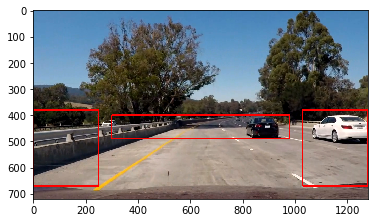

Horizon: 0.6 , Count: 11
Left: 1.4 , Count: 0
Right: 1.4 , Count: 4


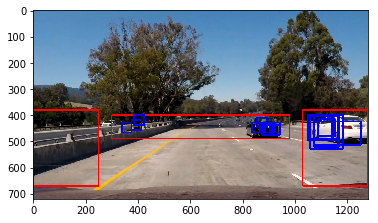

In [85]:
img = cv2.imread('test_images/scene7/scene1.png')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#img = img.astype(np.float32)/255
draw_img = np.copy(img)

all_boxes_img = np.copy(img)

new_horizon_cars = []
new_left_cars = []
new_right_cars = []
bboxes = []
t=time.time()
    
# to speed the search process we look for NEW cars in three locations, left, right and horizon.
# If we identified any cars in the last scene we also look in its last location based on its trajectory
search_box=[]
# Horizon search - in case we catch up to another car
y_start_stop = [400, 490]
x_start_stop = [300, 1280-300]
search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
scale_h1 = 0.6
new_horizon_cars1 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_h1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_h2 = 0.7
#new_horizon_cars2 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_h2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_h3 = 0.8
#new_horizon_cars3 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_h3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_h4 = 0.9
#new_horizon_cars4 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_h4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
new_horizon_cars = new_horizon_cars1#+new_horizon_cars2+new_horizon_cars3+new_horizon_cars4

side_search_size = 250
# Left side search - larger cars are likely to be higher
y_start_stop = [380, 670]
x_start_stop = [0, side_search_size]
search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
scale_l1 = 1.4
new_left_cars1 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_l1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_l2 = 1.4
#new_left_cars2 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_l2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_l3 = 1.6
#new_left_cars3 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_l3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_l4 = 1.7
#new_left_cars4 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_l4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
new_left_cars = new_left_cars1#+new_left_cars2+new_left_cars3+new_left_cars4

# Right side search - larger cars are likely to be higher
y_start_stop = [380, 670]
x_start_stop = [1280-side_search_size, 1280]
search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
scale_r1 = 1.4
new_right_cars1 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_r1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_r2 = 1.4
#new_right_cars2 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_r2, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_r3 = 1.6
#new_right_cars3 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_r3, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
#scale_r4 = 1.7
#new_right_cars4 = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_r4, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
new_right_cars = new_right_cars1#+new_right_cars2+new_right_cars3+new_right_cars4


# Now that we have looked for new cars lets check previous found cars
prev_tracked_cars = []
prev_tracked_cars += [((int(1050),int(450)),(int(1200), int(550)))]
#prev_tracked_cars += [((int(530), int(860)),(int(550),int(870)))]

tracked_search = []
if len(prev_tracked_cars)>0:
        new_tracked_cars = []
        for car in range(0,len(prev_tracked_cars)):
            #print("car:",car,"shape",len(car))
            x,y = get_car_centre(prev_tracked_cars[car])
            search_window_size = 100
            tracked_search.append(((int(x-search_window_size), int(y-search_window_size)),(int(x+search_window_size),int(y+search_window_size))))
            y_start = y-search_window_size
            if y_start<0: y_start=0
            y_stop = y+search_window_size
            if y_stop>720: y_stop = 720
            x_start=x-search_window_size
            if x_start<0: x_start=0
            x_stop = x+search_window_size
            if x_stop>1280: x_stop=1280
            print(y_start,y_stop, x_start, x_stop)
            scale = 1
            new_tracked_cars += find_cars(img, int(y_start),int(y_stop),int(x_start),int(x_stop), scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            scale = 1.5
            new_tracked_cars += find_cars(img, int(y_start),int(y_stop),int(x_start),int(x_stop), scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
            scale = 2
            new_tracked_cars += find_cars(img, int(y_start),int(y_stop),int(x_start),int(x_stop), scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if len(new_tracked_cars)>0:
            bboxes += new_tracked_cars

bboxes = new_horizon_cars + new_left_cars + new_right_cars + new_tracked_cars

print("Total:",len(bboxes))

t2=time.time()
print(round(t2-t, 2), 'Seconds to get bounding boxes...')

#draw the search locations on the image
all_boxes_img = draw_boxes(all_boxes_img, search_box , color=(255, 0, 0), thick=3)
#all_boxes_img = draw_boxes(all_boxes_img, tracked_search , color=(0, 255, 0), thick=3)

plt.imshow(all_boxes_img)
plt.show()

print("Horizon:",scale_h1,", Count:",len(new_horizon_cars1))
#print("Horizon:",scale_h2,", Count:",len(new_horizon_cars2))
#print("Horizon:",scale_h3,", Count:",len(new_horizon_cars3))
#print("Horizon:",scale_h4,", Count:",len(new_horizon_cars4))
print("Left:",scale_l1,", Count:",len(new_left_cars1))
#print("Left:",scale_l2,", Count:",len(new_left_cars2))
#print("Left:",scale_l3,", Count:",len(new_left_cars3))
#print("Left:",scale_l4,", Count:",len(new_left_cars4))
print("Right:",scale_r1,", Count:",len(new_right_cars1))
#print("Right:",scale_r2,", Count:",len(new_right_cars2))
#print("Right:",scale_r3,", Count:",len(new_right_cars3))
#print("Right:",scale_r4,", Count:",len(new_right_cars4))

window_image = draw_boxes(all_boxes_img, bboxes, color=(0, 0, 255), thick=6)
plt.imshow(window_image)
plt.show()

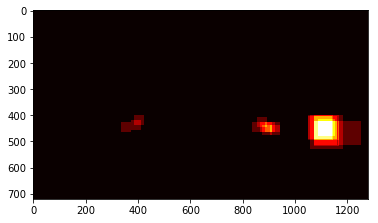

3 cars found


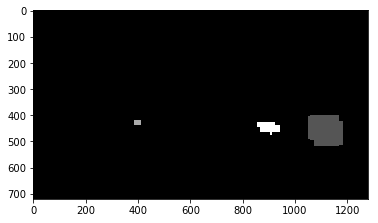

Fixed. Aspect: 0.5620915032679739 Height: 86 Width: 153 x: 1117.5 y 459.0
FAILED. Aspect: 0.666666666667 Height: 18 Width: 27 x: 399.5 y 428.0
Fixed. Aspect: 0.6507936507936508 Height: 82 Width: 126 x: 898.0 y 451.0


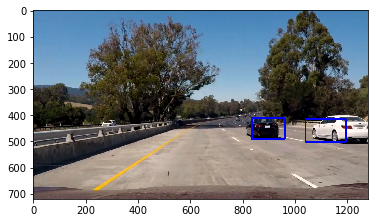

In [86]:
heat = np.zeros_like(img[:,:,0]).astype(np.float)
heat = add_heat(heat,bboxes)
plt.imshow(heat, cmap='hot', interpolation='nearest')
plt.show()

heatmap = apply_threshold(heat, 1.5)
labels = label(heatmap)
print(labels[1], 'cars found')
plt.imshow(labels[0], cmap='gray')
plt.show()

draw_img, no_cars = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.imshow(draw_img)
plt.show()

In [99]:
import math

R_ERROR=0.7
def track_new_centres(frames, x_pos, y_pos):
    new_x_pos = None
    new_y_pos = None
    if x_pos: 
        slope, intercept, r_value, p_value, std_err = stats.linregress(frames, x_pos)
        prev_frame = frames[-1]
        if r_value>R_ERROR or r_value<-1*R_ERROR:
            new_x_pos = slope*(prev_frame+1)+intercept # when we look at the next frame in x dir
            #print("Old x=",x_pos[-1])
            #print("New x=",new_x_pos)
        elif slope==0:
            new_x_pos = x_pos[-1]
            #print("Old x is New=",x_pos[-1])
    if y_pos: 
        slope, intercept, r_value, p_value, std_err = stats.linregress(frames, y_pos)
        prev_frame = frames[-1]
        if r_value>R_ERROR or r_value<-1*R_ERROR:
            new_y_pos = slope*(prev_frame+1)+intercept # when we look at the next frame in y dir
            #print("Old y=",y_pos[-1])
            #print("New y=",new_y_pos)
        elif slope==0:
            new_y_pos = y_pos[-1]
            #print("Old y is New=",y_pos[-1])
    return new_x_pos, new_y_pos

search_window_size = 200
def track_car(img, new_x, new_y, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    y_start = new_y-search_window_size
    if y_start<0: y_start=0
    y_stop = new_y+search_window_size
    if y_stop>720: y_stop = 720
    x_start=new_x-search_window_size
    if x_start<0: x_start=0
    x_stop = new_x+search_window_size
    if x_stop>1280: x_stop=1280

    new_tracked_cars = []
    if img.any():
        if y_start:
            if y_stop:
                if x_start:
                    scale = 1
                    new_tracked_cars += find_cars(img, int(y_start),int(y_stop),int(x_start),int(x_stop), scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
                    scale = 1.5
                    new_tracked_cars += find_cars(img, int(y_start),int(y_stop),int(x_start),int(x_stop), scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
                    scale = 2
                    new_tracked_cars += find_cars(img, int(y_start),int(y_stop),int(x_start),int(x_stop), scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    
    return new_tracked_cars

def process_image(img, prev_tracked_cars, prev_heat_maps, car_centres, vis=False):
    if img.any():
        all_boxes_img = np.copy(img)

        new_horizon_cars = []
        new_left_cars = []
        new_right_cars = []
        bboxes = []
        t=time.time()

        # to speed the search process we look for NEW cars in three locations, left, right and horizon.
        # If we identified any cars in the last scene we also look in its last location based on its trajectory
        search_box=[]
        # Horizon search - in case we catch up to another car
        y_start_stop = [390, 500]#[390, 470]
        x_start_stop = [280, 1280-280] #[350, 1280-350]
        search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
        scale_h1 = 0.6
        new_horizon_cars = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_h1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if new_horizon_cars:
            bboxes += new_horizon_cars#+new_horizon_cars2+new_horizon_cars3+new_horizon_cars4

        side_search_size = 280
        # Left side search - larger cars are likely to be higher
        y_start_stop = [380, 670]
        x_start_stop = [0, side_search_size]
        search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
        search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
        scale_l1 = 1.4
        new_left_cars = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_l1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if new_left_cars:
            bboxes += new_left_cars#+new_left_cars2+new_left_cars3+new_left_cars4

        # Right side search - larger cars are likely to be higher
        y_start_stop = [380, 670]
        x_start_stop = [1280-side_search_size, 1280]
        search_box.append(((int(x_start_stop[0]), int(y_start_stop[0])),(int(x_start_stop[1]),int(y_start_stop[1]))))
        scale_r1 = 1.4
        new_right_cars = find_cars(img, y_start_stop[0], y_start_stop[1], x_start_stop[0], x_start_stop[1], scale_r1, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
        if new_right_cars:
            bboxes += new_right_cars
            
        # Now that we have looked for new cars lets check previous found cars

        ### TODO: Find a better way to track cars,
        ### currently this is hard coded to 4 cars
        ### need to manage which cars are which and seperate coordinates
        R_ERROR =0.7 # this is for the linear regression, what corelation will we accept
        search_window_size = 100 # how large of a search area will we accept
        if len(car_centres)>0:
            new_tracked_cars=[]
            x0=[]
            y0=[]
            x1=[]
            y1=[]
            x2=[]
            y2=[]
            x3=[]
            y3=[]
            frames0=[]
            frames1=[]
            frames2=[]
            frames3=[]
            prev_frame = []
            new_x = None
            new_y = None

            g_max_cars=0
            for frame in range(0,len(car_centres)):
                l_max_cars=0
                for car in range(0,len(car_centres[frame])):
                    l_max_cars+=1#print(car)
                    if car == 0:  
                        x0.append(car_centres[frame][car][0])
                        y0.append(car_centres[frame][car][1])
                        frames0.append(frame)
                    if car == 1:  
                        x1.append(car_centres[frame][car][0])
                        y1.append(car_centres[frame][car][1])
                        frames1.append(frame)
                    if car == 2:  
                        x2.append(car_centres[frame][car][0])
                        y2.append(car_centres[frame][car][1])
                        frames2.append(frame)
                    if car == 3:  
                        x3.append(car_centres[frame][car][0])
                        y3.append(car_centres[frame][car][1])
                        frames3.append(frame)

                if l_max_cars > g_max_cars: g_max_cars = l_max_cars

            #print("max cars:",g_max_cars) 
            #print("x0:",x0)
            #print("y0:",y0)

            #print("x1:",x1)
            #print("y1:",y1)

            #print("x2:",x2)
            #print("y2:",y2)

            #print("x3:",x3)
            #print("y3:",y3)

            #print("Frames0:",frames0)
            #print("Frames1:",frames1)
            #print("Frames2:",frames2)
            #print("Frames3:",frames3)

            new_x, new_y = track_new_centres(frames0, x0, y0)
            if new_x:
                if new_y:
                    new_tracked_cars += track_car(img, new_x, new_y, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

            new_x, new_y = track_new_centres(frames1, x1, y1)
            if new_x:
                if new_y:
                    new_tracked_cars += track_car(img, new_x, new_y, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

            new_x, new_y = track_new_centres(frames2, x2, y2)
            if new_x:
                if new_y:
                    new_tracked_cars += track_car(img, new_x, new_y, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

            new_x, new_y = track_new_centres(frames3, x3, y3)
            if new_x:
                if new_y:
                    new_tracked_cars += track_car(img, new_x, new_y, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

            if len(new_tracked_cars)>0:
                bboxes += new_tracked_cars

        heat = np.zeros_like(img[:,:,0]).astype(np.float)
        heat = add_heat(heat,bboxes)


        heatmap = apply_threshold(heat,1.5)

        av_heat_map = heatmap
        for heat_map_index in range(0,len(prev_heat_maps)):
            av_heat_map = cv2.addWeighted(av_heat_map,0.7,prev_heat_maps[heat_map_index],1-heat_map_index/len(prev_heat_maps),0)

        # trim of any fading pixels
        av_heat_map = apply_threshold(av_heat_map, 1.5) 

        # get the labels of each blob from the heat map
        labels = label(av_heat_map)

        processed_img, no_cars, box = draw_labeled_bboxes(np.copy(img), labels, return_boxes=True)
        #print("Cars Tracked: ", no_cars)
        processed_img = draw_boxes(processed_img, search_box , color=(0, 255, 0), thick=5)
        all_boxes_img = draw_boxes(processed_img, bboxes , color=(255, 0, 0), thick=3)
        if vis==True:
            plt.figure(figsize=(20,10))
            plt.subplot(151)
            plt.imshow(all_boxes_img)
            plt.title("All boxes")

            plt.subplot(152)
            plt.imshow(heat, cmap='hot')
            plt.title("New Raw Heat Map")

            plt.subplot(153)
            plt.imshow(av_heat_map, cmap='hot')
            plt.title("Averaged Heat Map")

            plt.subplot(154)
            plt.imshow(labels[0], cmap='gray')
            plt.title("Labels")

            plt.subplot(155)
            plt.imshow(processed_img)
            plt.title("Processed")

            plt.show()

        return heatmap, av_heat_map, processed_img, box
    else:
        return img

from scipy import stats
def process_video(img, debug_vis=False):
    global prev_bboxes, prev_heat_maps, car_centres
    draw_plots = True #True
    new_heat_map, av_heat_map, new_processed_img, new_bboxes = process_image(np.copy(img), prev_bboxes, prev_heat_maps, car_centres, vis=draw_plots)
    
    new_car_centres = []
    for box in range(0,len(new_bboxes)):
        x,y = get_car_centre(new_bboxes[box])
        new_car_centres.append((x,y))
    
    car_centres.insert(0,new_car_centres)
    if len(car_centres)>5:
        car_centres.pop()
  
    # PLot previous bounding boxes
    #if len(prev_bboxes) > 0:
        #for box_index in range(2,len(prev_bboxes),2):
            #print("Adding previous boxes in white, len, len[i], i", len(prev_bboxes), len(prev_bboxes[box_index]))
            #print("Total len boxes", len(prev_bboxes))
            #print("Number cars in box is: " + str(len(prev_bboxes[box_index])) + " at index " + str(box_index))
            #processed_img = draw_boxes(processed_img, prev_bboxes[box_index], color=(255, 255, 255), thick=1)

    prev_heat_maps.insert(0,new_heat_map)
    #print("prev_bboxes", prev_bboxes)
    if len(prev_heat_maps) > 10:
        prev_heat_maps.pop() 
        
    prev_bboxes = new_bboxes
    
    #if len(bboxes)>0:
    #    print("tracked cars:",bboxes)
    #    prev_bboxes.insert(0,bboxes)
    #    print("pb inserted:",prev_bboxes)
    #print("prev_bboxes", prev_bboxes)
    #    if len(prev_bboxes) > 10:
    #        prev_bboxes.pop() 
    #        print("pb poped:",prev_bboxes)
        
    if debug_vis:
        return new_processed_img, labels, av_heat_map, new_heat_map
    
    return new_processed_img
    

### Test the pipeline with images

FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 908.0 y 446.5
Fixed. Aspect: 0.5409836065573771 Height: 99 Width: 183 x: 1166.5 y 490.5


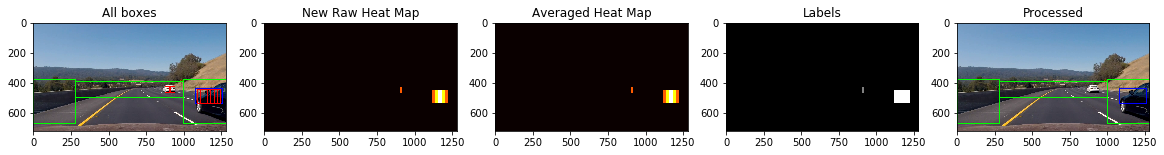

2.46 Seconds to process frame
Fixed. Aspect: 0.5487804878048781 Height: 90 Width: 164 x: 1166.0 y 468.0
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 908.0 y 446.5


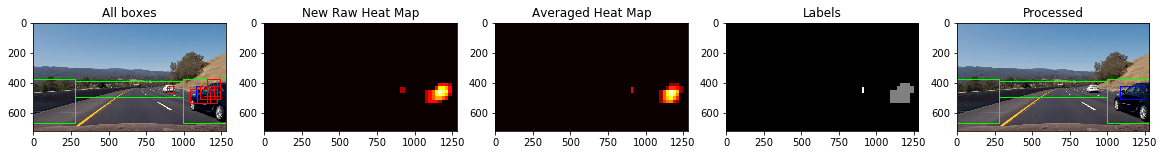

2.19 Seconds to process frame
Fixed. Aspect: 0.5548780487804879 Height: 91 Width: 164 x: 1153.0 y 468.5
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 908.0 y 446.5


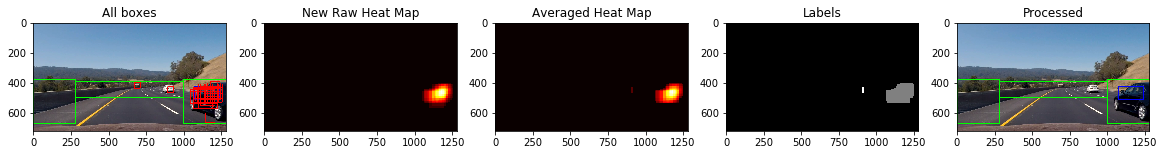

2.96 Seconds to process frame
Fixed. Aspect: 0.5542168674698795 Height: 92 Width: 166 x: 1146.0 y 472.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


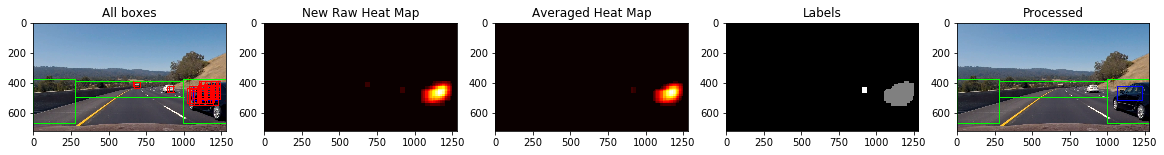

3.03 Seconds to process frame
Fixed. Aspect: 0.5575757575757576 Height: 92 Width: 165 x: 1144.5 y 472.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


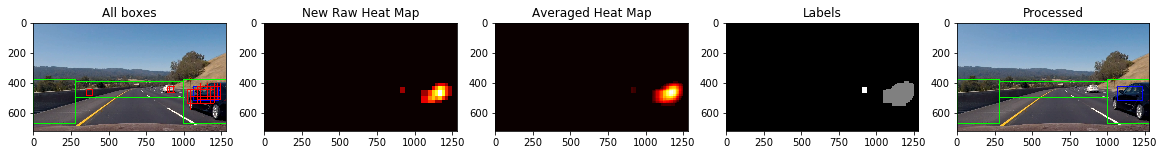

2.02 Seconds to process frame
Fixed. Aspect: 0.5502958579881657 Height: 93 Width: 169 x: 1144.5 y 476.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


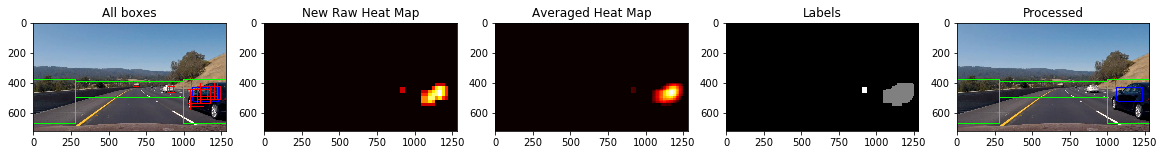

2.64 Seconds to process frame
Fixed. Aspect: 0.5502958579881657 Height: 93 Width: 169 x: 1143.5 y 476.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


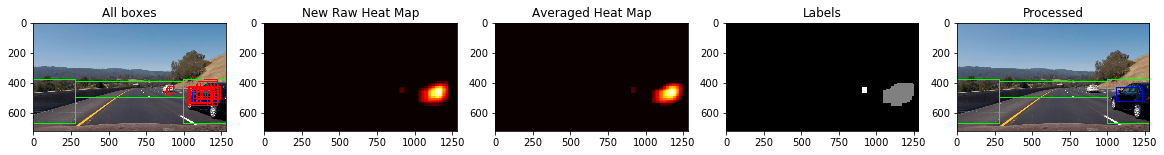

3.15 Seconds to process frame
Fixed. Aspect: 0.5481927710843374 Height: 91 Width: 166 x: 1141.0 y 472.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


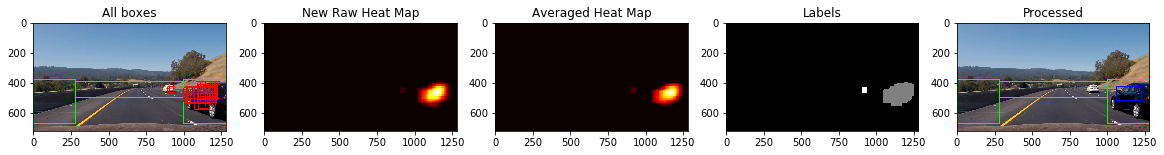

2.69 Seconds to process frame
Fixed. Aspect: 0.5535714285714286 Height: 93 Width: 168 x: 1141.0 y 476.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


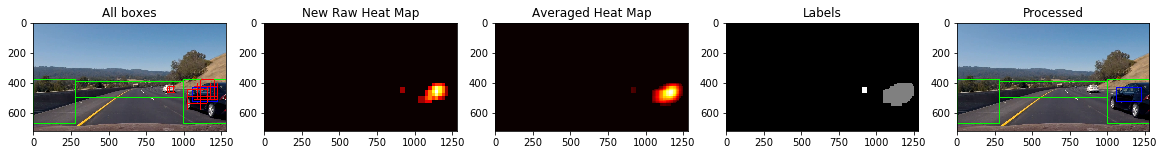

2.48 Seconds to process frame
Fixed. Aspect: 0.5535714285714286 Height: 93 Width: 168 x: 1141.0 y 476.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


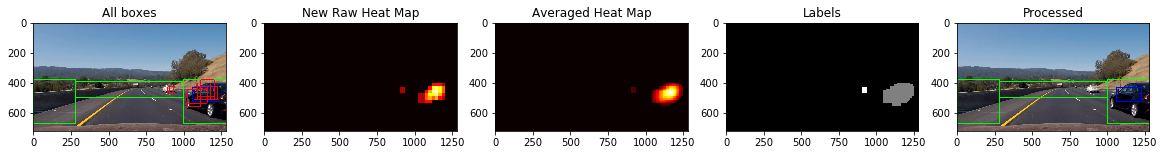

2.33 Seconds to process frame
Fixed. Aspect: 0.5535714285714286 Height: 93 Width: 168 x: 1141.0 y 476.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


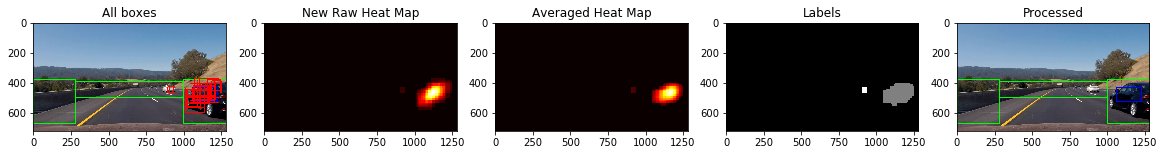

2.97 Seconds to process frame
Fixed. Aspect: 0.5502958579881657 Height: 93 Width: 169 x: 1140.5 y 476.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


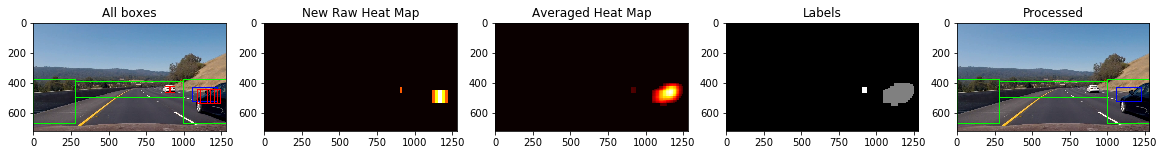

2.96 Seconds to process frame
Fixed. Aspect: 0.5515151515151515 Height: 91 Width: 165 x: 1133.5 y 472.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


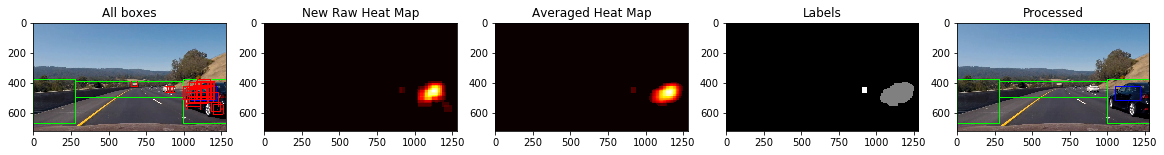

3.66 Seconds to process frame
Fixed. Aspect: 0.5515151515151515 Height: 91 Width: 165 x: 1126.5 y 472.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


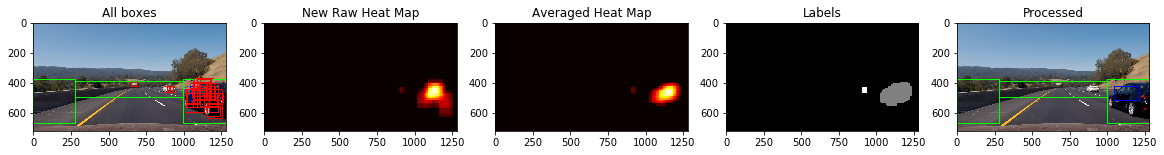

3.45 Seconds to process frame
Fixed. Aspect: 0.5609756097560976 Height: 92 Width: 164 x: 1122.0 y 474.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


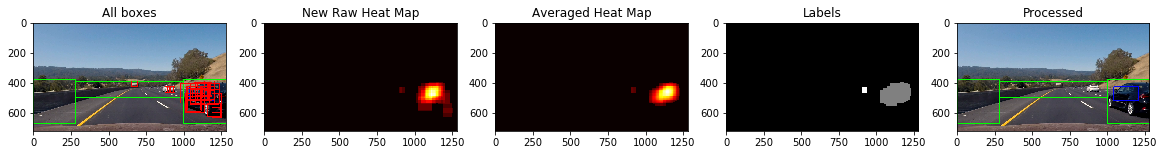

3.4 Seconds to process frame
Fixed. Aspect: 0.5662650602409639 Height: 94 Width: 166 x: 1122.0 y 475.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


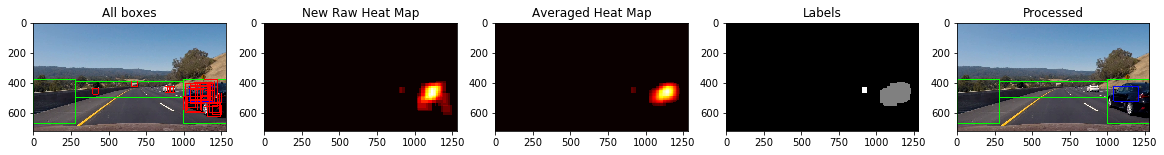

3.18 Seconds to process frame
Fixed. Aspect: 0.5696969696969697 Height: 94 Width: 165 x: 1120.5 y 475.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


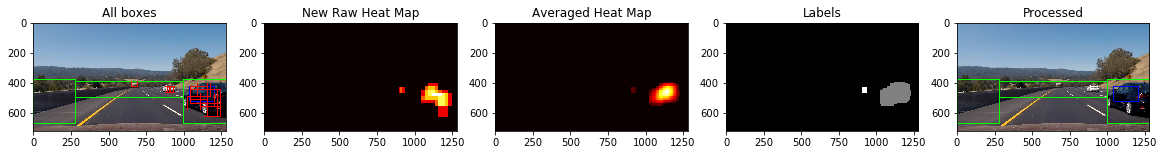

2.81 Seconds to process frame
Fixed. Aspect: 0.5654761904761905 Height: 95 Width: 168 x: 1119.0 y 477.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


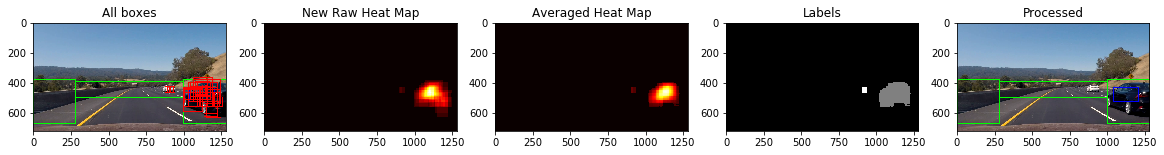

3.27 Seconds to process frame
Fixed. Aspect: 0.5647058823529412 Height: 96 Width: 170 x: 1123.0 y 480.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


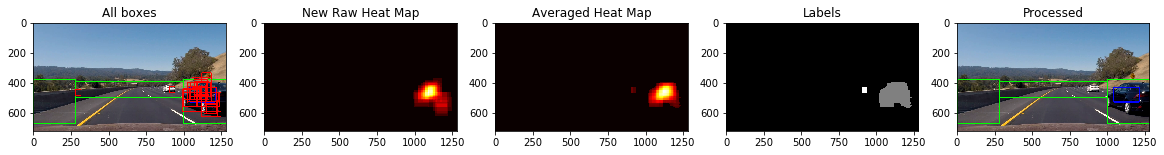

3.62 Seconds to process frame
Fixed. Aspect: 0.5586592178770949 Height: 100 Width: 179 x: 1124.5 y 492.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


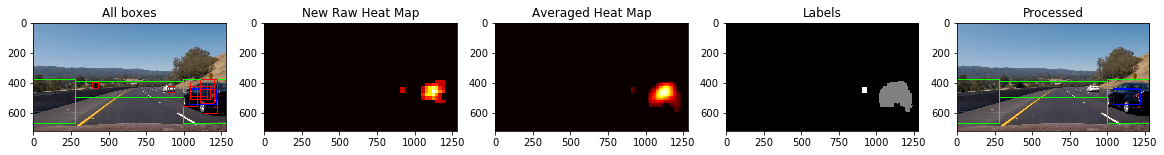

3.38 Seconds to process frame
Fixed. Aspect: 0.554945054945055 Height: 101 Width: 182 x: 1128.0 y 494.5
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


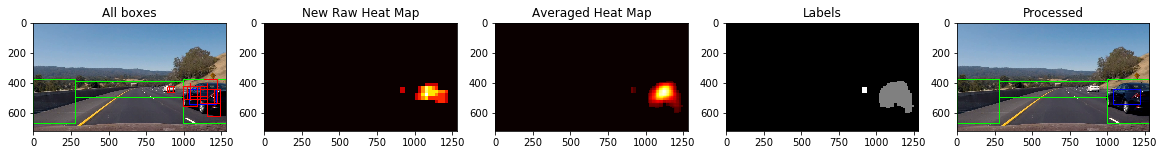

3.88 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1127.5 y 499.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


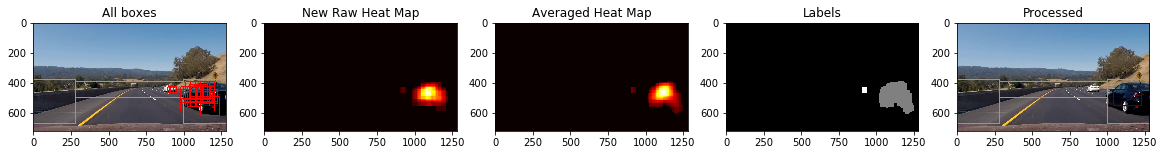

4.01 Seconds to process frame
Fixed. Aspect: 0.5531914893617021 Height: 104 Width: 188 x: 1127.0 y 502.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


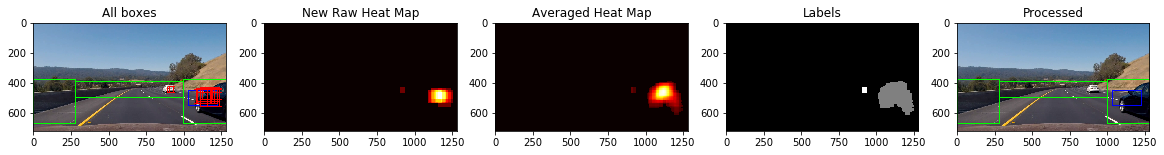

4.22 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1121.5 y 501.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


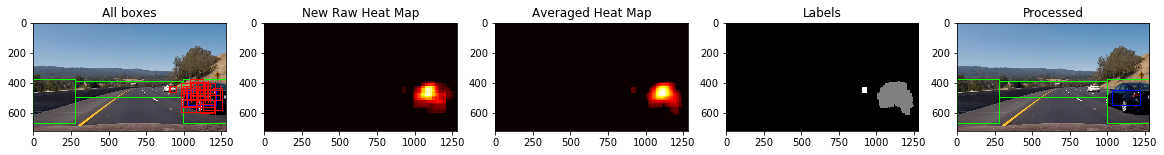

4.02 Seconds to process frame
Fixed. Aspect: 0.5652173913043478 Height: 104 Width: 184 x: 1118.0 y 498.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


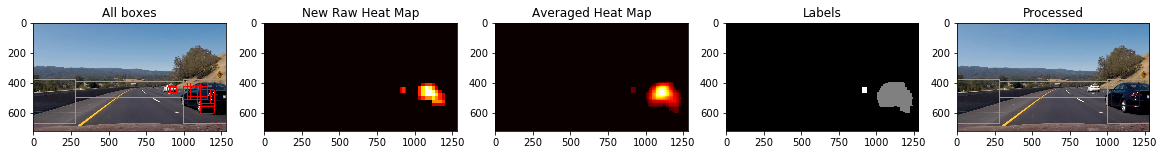

3.02 Seconds to process frame
Fixed. Aspect: 0.5714285714285714 Height: 104 Width: 182 x: 1117.0 y 498.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


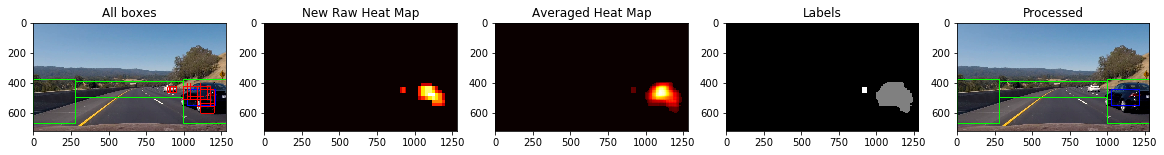

3.2 Seconds to process frame
Fixed. Aspect: 0.5617977528089888 Height: 100 Width: 178 x: 1117.0 y 492.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


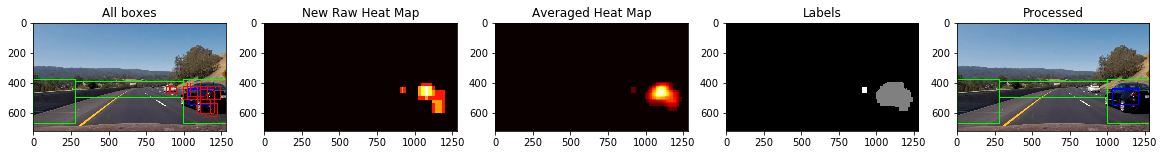

3.15 Seconds to process frame
Fixed. Aspect: 0.5586592178770949 Height: 100 Width: 179 x: 1116.5 y 492.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


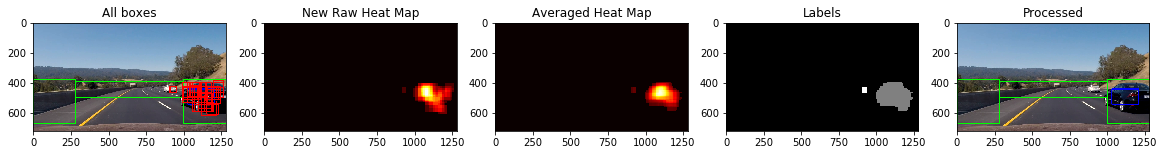

3.99 Seconds to process frame
Fixed. Aspect: 0.5674157303370787 Height: 101 Width: 178 x: 1111.0 y 491.5
FAILED. Aspect: 2.05555555556 Height: 37 Width: 18 x: 922.0 y 446.5


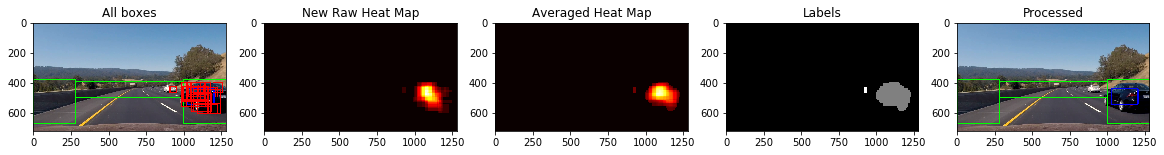

3.17 Seconds to process frame
Fixed. Aspect: 0.5586592178770949 Height: 100 Width: 179 x: 1114.5 y 492.0
FAILED. Aspect: 1.37037037037 Height: 37 Width: 27 x: 917.5 y 446.5


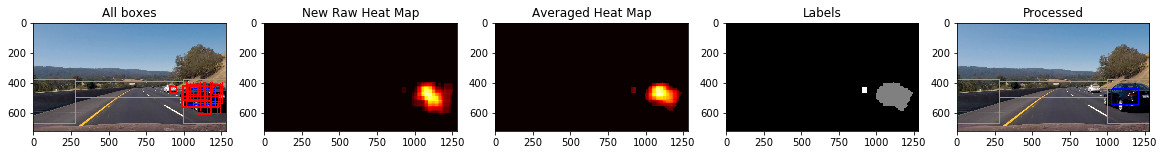

3.68 Seconds to process frame
Fixed. Aspect: 0.5666666666666667 Height: 102 Width: 180 x: 1115.0 y 495.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


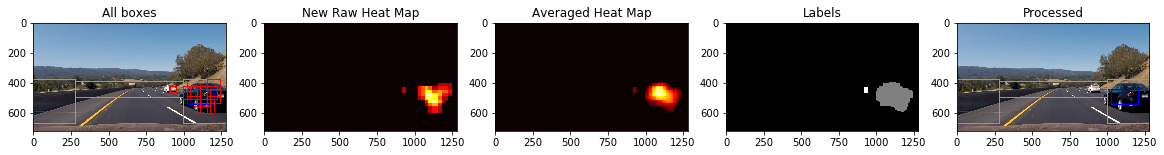

2.79 Seconds to process frame
Fixed. Aspect: 0.5628415300546448 Height: 103 Width: 183 x: 1117.5 y 497.5
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


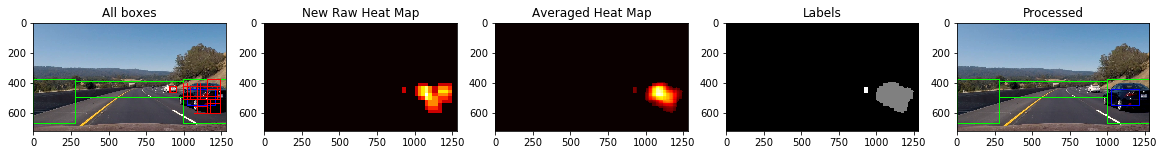

3.21 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1118.5 y 500.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


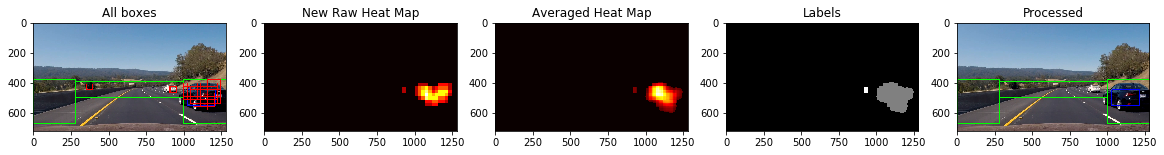

2.57 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1118.5 y 500.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


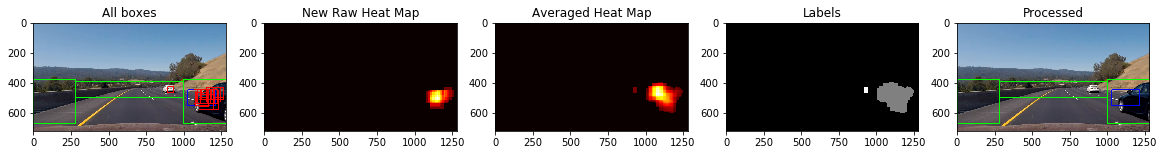

3.25 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1121.5 y 501.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


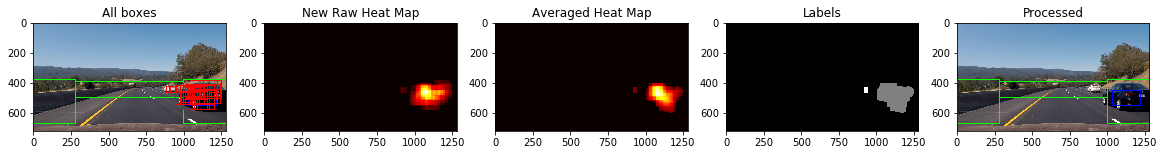

3.15 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1117.5 y 500.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


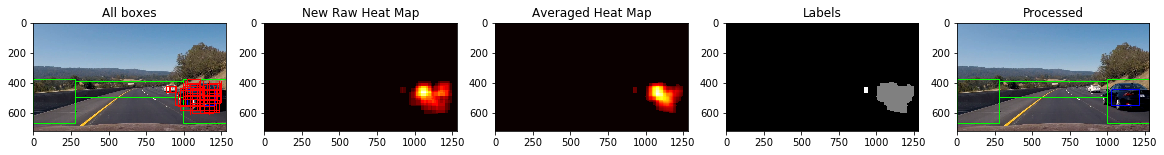

3.64 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1117.5 y 500.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


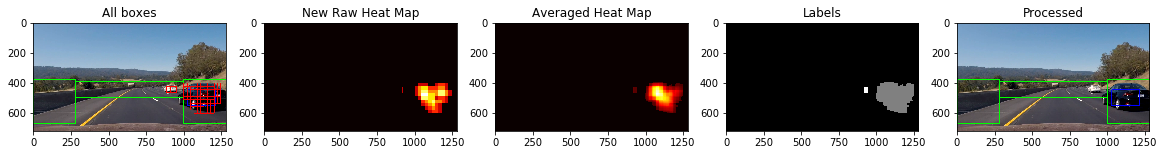

2.56 Seconds to process frame
Fixed. Aspect: 0.5652173913043478 Height: 104 Width: 184 x: 1117.0 y 500.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


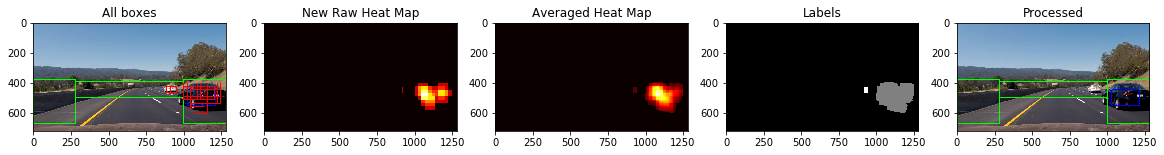

2.8 Seconds to process frame
Fixed. Aspect: 0.5621621621621622 Height: 104 Width: 185 x: 1117.5 y 500.0
FAILED. Aspect: 1.32142857143 Height: 37 Width: 28 x: 927.0 y 446.5


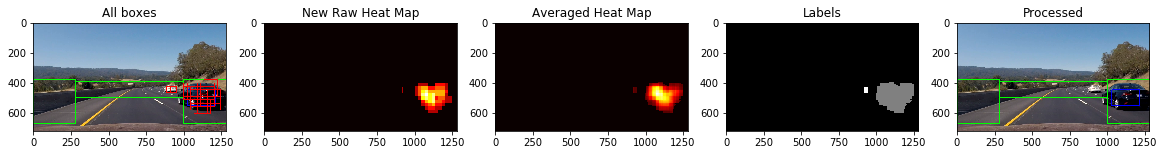

3.23 Seconds to process frame
Fixed. Aspect: 0.5675675675675675 Height: 105 Width: 185 x: 1117.5 y 501.5
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


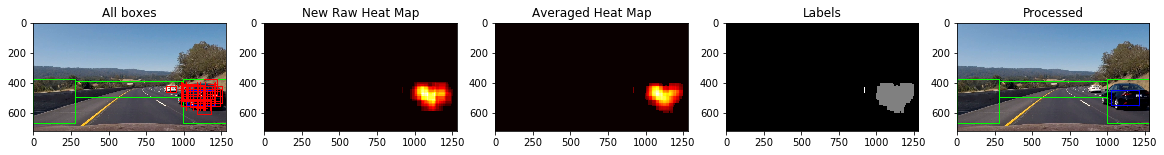

3.5 Seconds to process frame
Fixed. Aspect: 0.5666666666666667 Height: 102 Width: 180 x: 1116.0 y 494.0
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


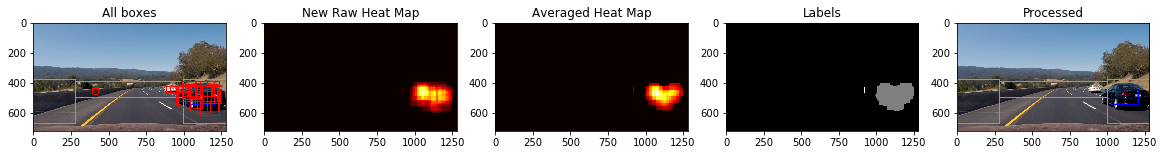

2.79 Seconds to process frame
Fixed. Aspect: 0.5642458100558659 Height: 101 Width: 179 x: 1113.5 y 493.5
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


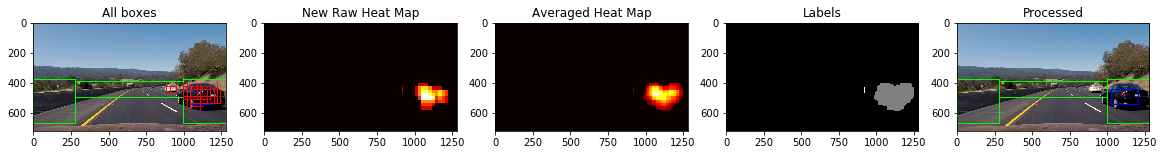

2.87 Seconds to process frame
Fixed. Aspect: 0.5698324022346368 Height: 102 Width: 179 x: 1110.5 y 494.0
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


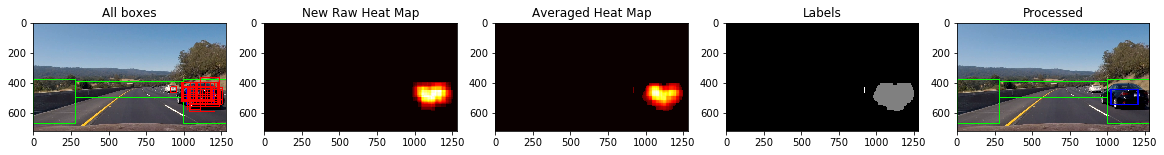

3.28 Seconds to process frame
Fixed. Aspect: 0.5706214689265536 Height: 101 Width: 177 x: 1110.5 y 492.5
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


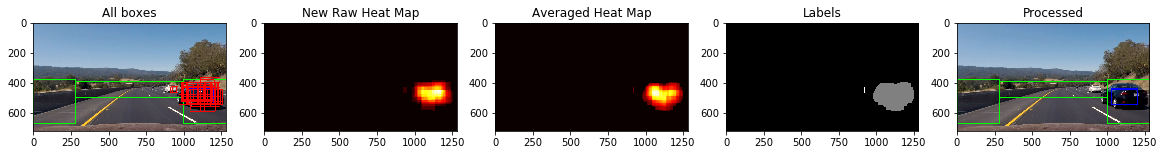

3.41 Seconds to process frame
Fixed. Aspect: 0.5649717514124294 Height: 100 Width: 177 x: 1110.5 y 492.0
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


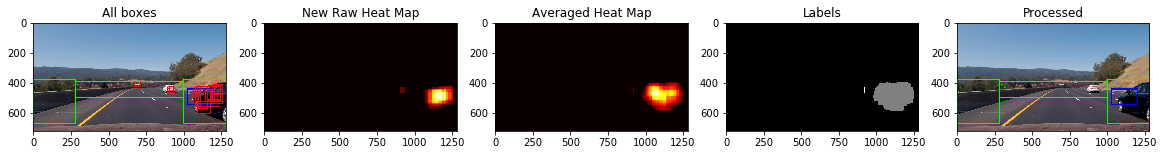

3.78 Seconds to process frame
Fixed. Aspect: 0.5649717514124294 Height: 100 Width: 177 x: 1112.5 y 492.0
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


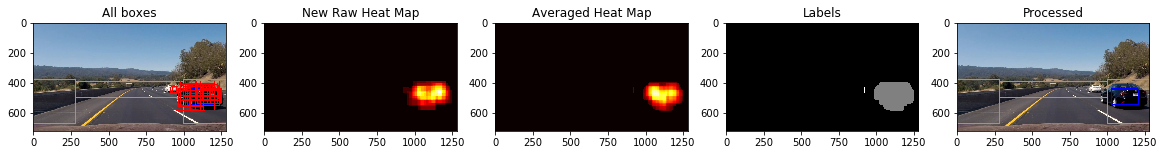

2.9 Seconds to process frame
Fixed. Aspect: 0.5649717514124294 Height: 100 Width: 177 x: 1113.5 y 492.0
FAILED. Aspect: 4.625 Height: 37 Width: 8 x: 917.0 y 446.5


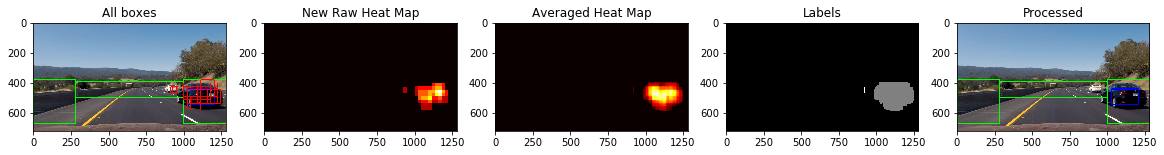

2.23 Seconds to process frame
Fixed. Aspect: 0.5649717514124294 Height: 100 Width: 177 x: 1116.5 y 491.0


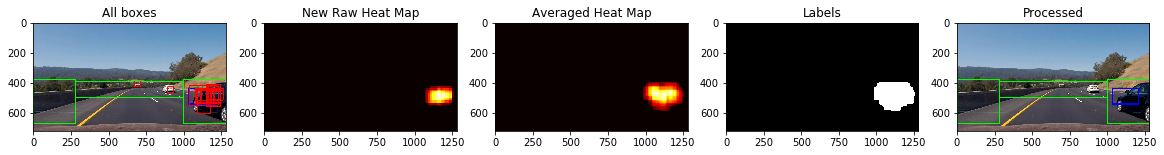

4.12 Seconds to process frame
Fixed. Aspect: 0.5617977528089888 Height: 100 Width: 178 x: 1116.0 y 491.0


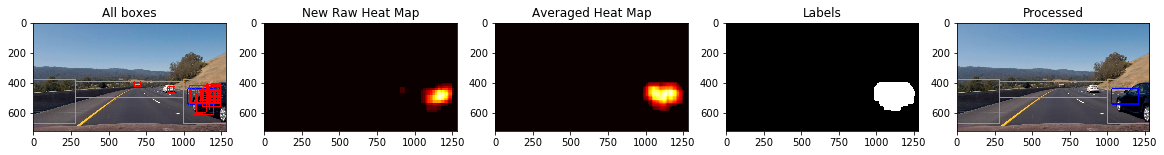

2.96 Seconds to process frame
Fixed. Aspect: 0.5649717514124294 Height: 100 Width: 177 x: 1116.5 y 491.0


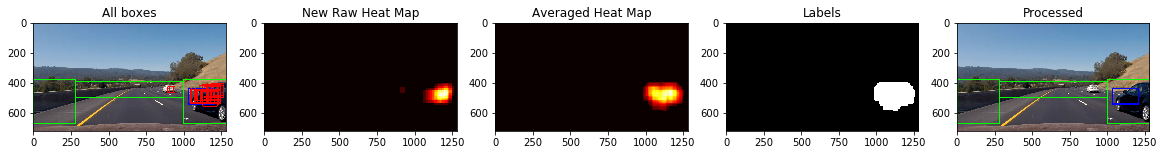

3.22 Seconds to process frame
Fixed. Aspect: 0.5625 Height: 99 Width: 176 x: 1117.0 y 488.5


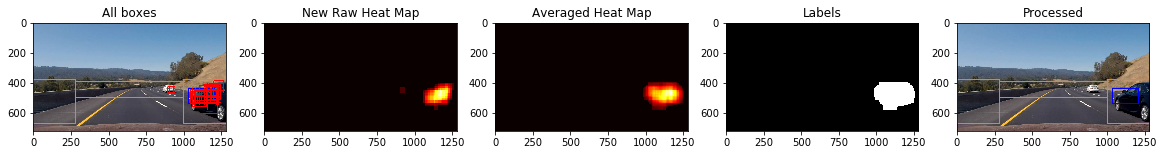

2.82 Seconds to process frame


In [98]:
%matplotlib inline
prev_bboxes = []
prev_heat_maps = []
car_centres = []


test_images = glob.glob('test_images/scene6/*.png')
i=0
for file in test_images:
    global i
    i +=1
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    t=time.time()
    processed_img, labels, av_heatmap, new_heatmap = process_video(image, debug_vis=True)
    t2=time.time()
    print(round(t2-t, 2), 'Seconds to process frame')


Fixed. Aspect: 0.6435643564356436 Height: 65 Width: 101 x: 412.5 y 412.5
Fixed. Aspect: 0.5448717948717948 Height: 85 Width: 156 x: 1166.0 y 456.5
Fixed. Aspect: 0.6637931034482759 Height: 77 Width: 116 x: 888.0 y 436.5


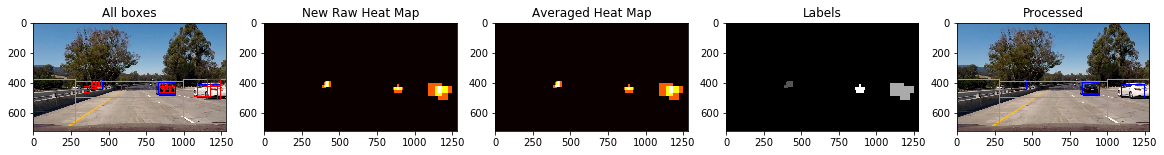

2.86 Seconds to process frame
Fixed. Aspect: 0.6435643564356436 Height: 65 Width: 101 x: 412.5 y 412.5
Fixed. Aspect: 0.5448717948717948 Height: 85 Width: 156 x: 1166.0 y 456.5
FAILED. Aspect: 2.0 Height: 18 Width: 9 x: 312.5 y 418.0
Fixed. Aspect: 0.6637931034482759 Height: 77 Width: 116 x: 878.0 y 436.5


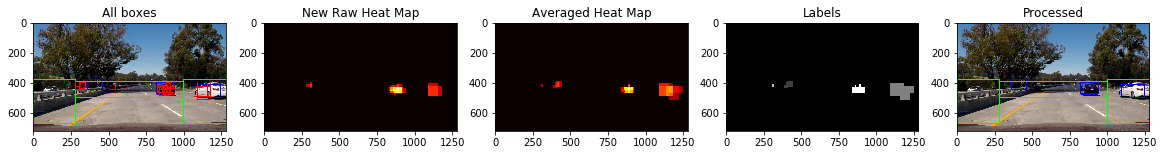

2.58 Seconds to process frame
car box windows found too high and removed
car box windows found too high and removed
car box windows found too high and removed
Fixed. Aspect: 0.6608695652173913 Height: 76 Width: 115 x: 889.5 y 435.0
FAILED. Aspect: 1.55555555556 Height: 28 Width: 18 x: 413.0 y 413.0
Fixed. Aspect: 0.5592105263157895 Height: 85 Width: 152 x: 1137.0 y 455.5
FAILED. Aspect: 2.0 Height: 18 Width: 9 x: 312.5 y 418.0


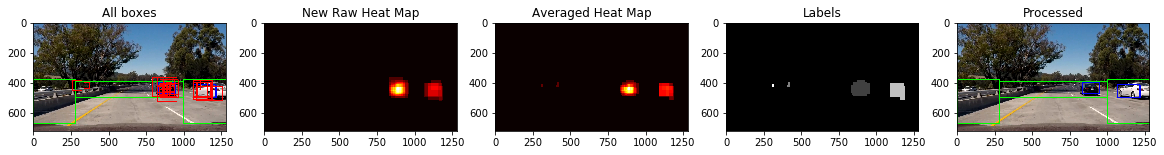

4.95 Seconds to process frame
Fixed. Aspect: 0.6607142857142857 Height: 74 Width: 112 x: 893.0 y 431.0
Fixed. Aspect: 0.5616438356164384 Height: 82 Width: 146 x: 1144.0 y 448.0


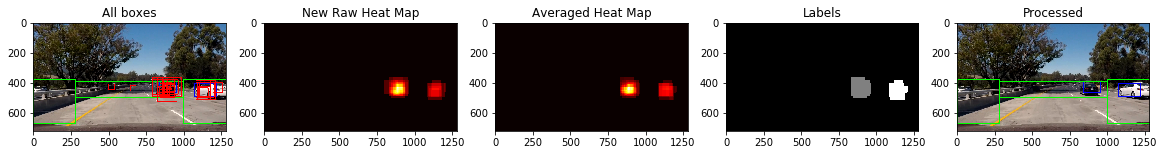

3.34 Seconds to process frame
Fixed. Aspect: 0.6607142857142857 Height: 74 Width: 112 x: 893.0 y 431.0
Fixed. Aspect: 0.5472972972972973 Height: 81 Width: 148 x: 1136.0 y 449.5


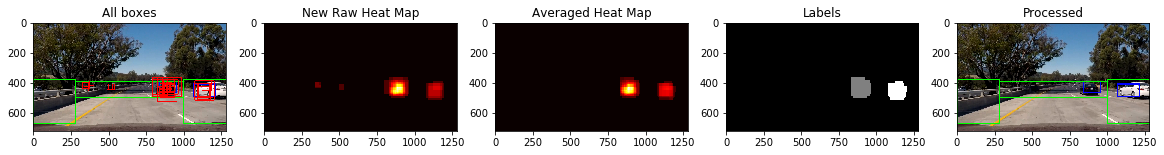

3.41 Seconds to process frame
car box windows found too high and removed
car box windows found too high and removed
car box windows found too high and removed
car box windows found too high and removed
Fixed. Aspect: 0.6607142857142857 Height: 74 Width: 112 x: 877.0 y 431.0
Fixed. Aspect: 0.5616438356164384 Height: 82 Width: 146 x: 1140.0 y 449.0


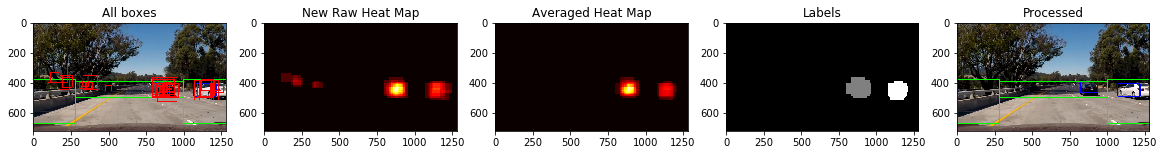

4.36 Seconds to process frame
Fixed. Aspect: 0.6607142857142857 Height: 74 Width: 112 x: 880.0 y 431.0
Fixed. Aspect: 0.5540540540540541 Height: 82 Width: 148 x: 1144.0 y 449.0
FAILED. Aspect: 3.5 Height: 28 Width: 8 x: 341.0 y 413.0


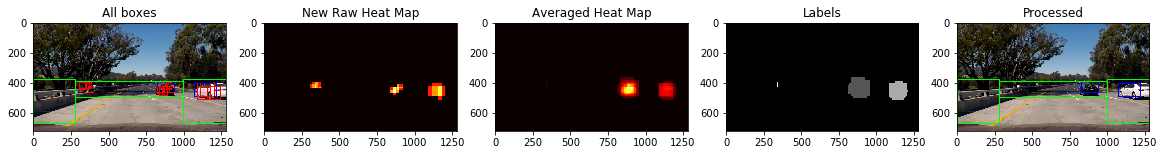

2.04 Seconds to process frame
Fixed. Aspect: 0.6666666666666666 Height: 74 Width: 111 x: 880.5 y 431.0
Fixed. Aspect: 0.5472972972972973 Height: 81 Width: 148 x: 1140.0 y 449.5
FAILED. Aspect: 3.5 Height: 28 Width: 8 x: 341.0 y 413.0


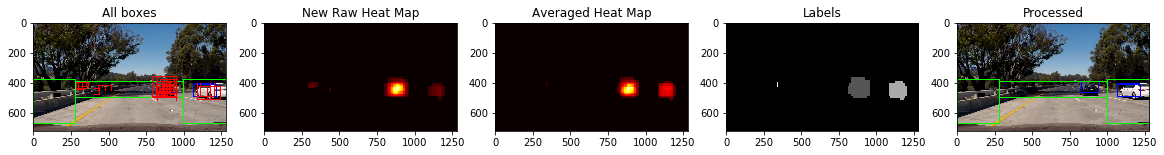

3.28 Seconds to process frame
Fixed. Aspect: 0.6666666666666666 Height: 74 Width: 111 x: 880.5 y 431.0
Fixed. Aspect: 0.5510204081632653 Height: 81 Width: 147 x: 1142.5 y 449.5
FAILED. Aspect: 2.25 Height: 18 Width: 8 x: 341.0 y 418.0


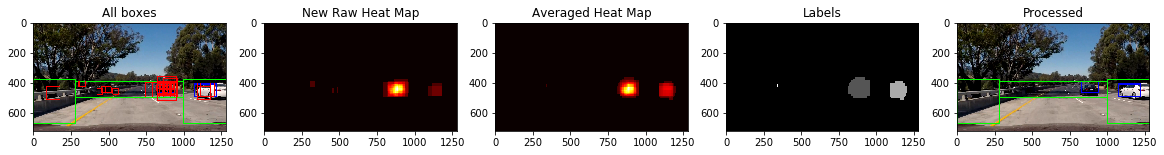

2.87 Seconds to process frame
Fixed. Aspect: 0.6607142857142857 Height: 74 Width: 112 x: 884.0 y 431.0
Fixed. Aspect: 0.5555555555555556 Height: 85 Width: 153 x: 1142.5 y 455.5


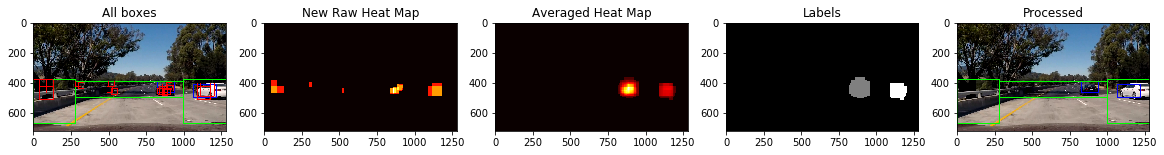

2.2 Seconds to process frame
car box windows found too high and removed
Fixed. Aspect: 0.6521739130434783 Height: 75 Width: 115 x: 884.5 y 435.5
Fixed. Aspect: 0.5592105263157895 Height: 85 Width: 152 x: 1144.0 y 455.5


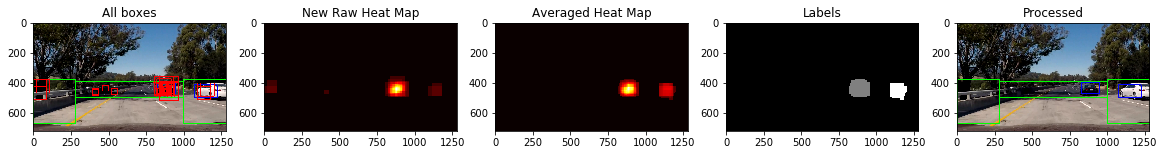

3.49 Seconds to process frame
Fixed. Aspect: 0.6607142857142857 Height: 74 Width: 112 x: 880.0 y 431.0
Fixed. Aspect: 0.5555555555555556 Height: 85 Width: 153 x: 1142.5 y 455.5


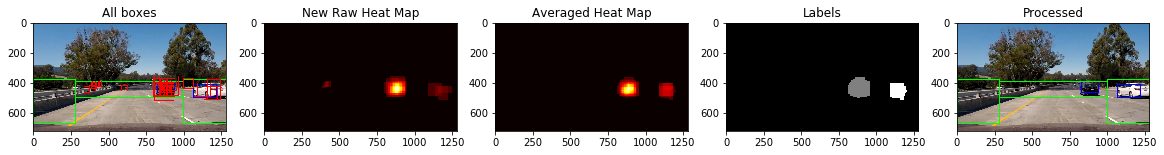

4.23 Seconds to process frame
Fixed. Aspect: 0.6607142857142857 Height: 74 Width: 112 x: 878.0 y 431.0
FAILED. Aspect: 3.5 Height: 28 Width: 8 x: 341.0 y 413.0
Fixed. Aspect: 0.5592105263157895 Height: 85 Width: 152 x: 1144.0 y 455.5


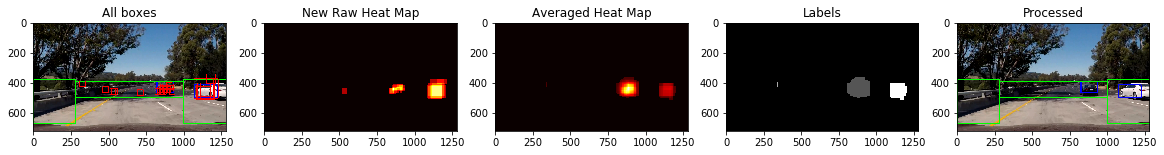

3.8 Seconds to process frame
Fixed. Aspect: 0.6578947368421053 Height: 75 Width: 114 x: 878.0 y 434.5
FAILED. Aspect: 2.0 Height: 28 Width: 14 x: 338.0 y 413.0
FAILED. Aspect: 3.5 Height: 28 Width: 8 x: 351.0 y 413.0
Fixed. Aspect: 0.5592105263157895 Height: 85 Width: 152 x: 1144.0 y 455.5


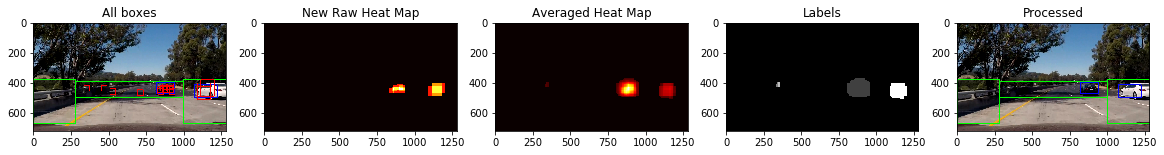

2.56 Seconds to process frame
Fixed. Aspect: 0.6578947368421053 Height: 75 Width: 114 x: 879.0 y 435.5
FAILED. Aspect: 1.64705882353 Height: 28 Width: 17 x: 336.5 y 413.0
Fixed. Aspect: 0.5540540540540541 Height: 82 Width: 148 x: 1144.0 y 450.0
FAILED. Aspect: 2.25 Height: 18 Width: 8 x: 322.0 y 418.0


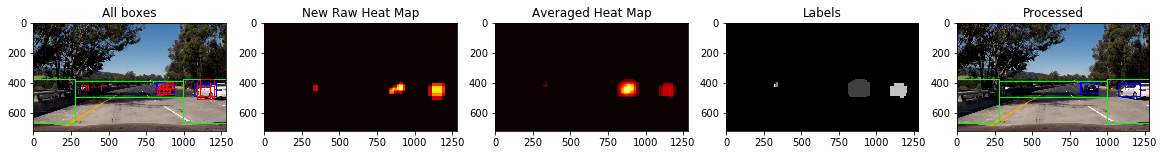

2.58 Seconds to process frame
Fixed. Aspect: 0.6578947368421053 Height: 75 Width: 114 x: 879.0 y 435.5
Fixed. Aspect: 0.5472972972972973 Height: 81 Width: 148 x: 1144.0 y 449.5
FAILED. Aspect: 2.25 Height: 18 Width: 8 x: 332.0 y 418.0


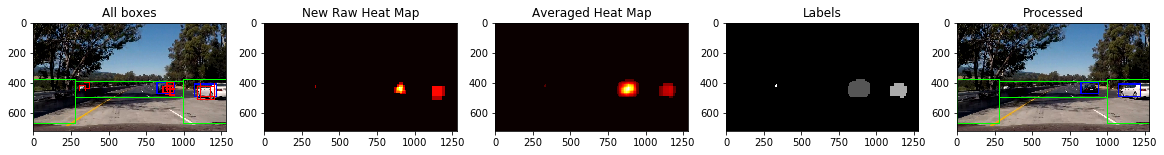

2.25 Seconds to process frame
Fixed. Aspect: 0.6578947368421053 Height: 75 Width: 114 x: 883.0 y 435.5
Fixed. Aspect: 0.5625 Height: 81 Width: 144 x: 1144.0 y 445.5


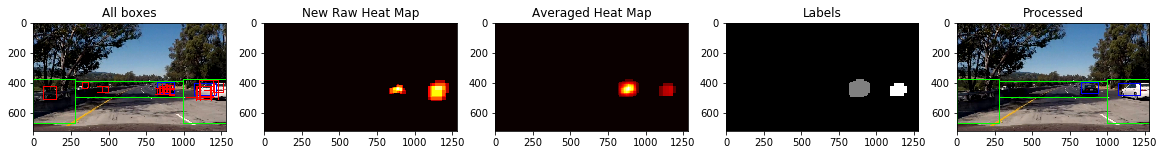

3.4 Seconds to process frame
car box windows found too high and removed
car box windows found too high and removed
Fixed. Aspect: 0.6521739130434783 Height: 75 Width: 115 x: 878.5 y 435.5
Fixed. Aspect: 0.5472972972972973 Height: 81 Width: 148 x: 1144.0 y 449.5


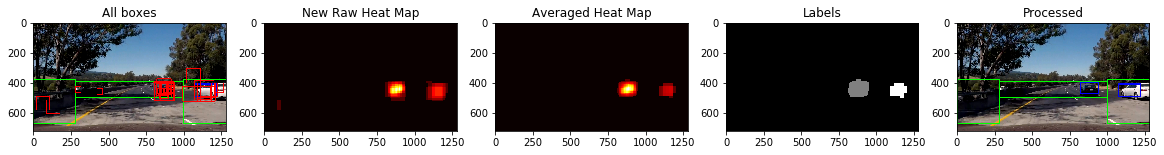

5.03 Seconds to process frame
car box windows found too high and removed
car box windows found too high and removed
Fixed. Aspect: 0.6610169491525424 Height: 78 Width: 118 x: 880.0 y 440.0
Fixed. Aspect: 0.5533333333333333 Height: 83 Width: 150 x: 1144.0 y 451.5


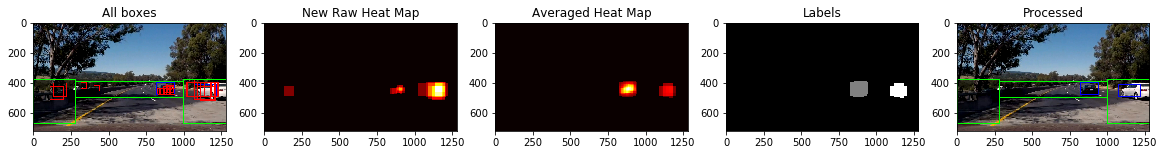

3.95 Seconds to process frame
Fixed. Aspect: 0.6610169491525424 Height: 78 Width: 118 x: 880.0 y 440.0
Fixed. Aspect: 0.5592105263157895 Height: 85 Width: 152 x: 1144.0 y 455.5


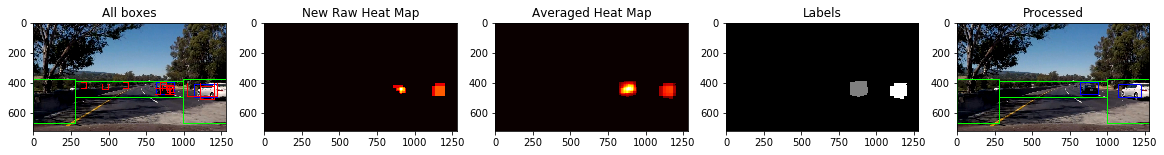

2.25 Seconds to process frame
car box windows found too high and removed
car box windows found too high and removed
car box windows found too high and removed
Fixed. Aspect: 0.6551724137931034 Height: 76 Width: 116 x: 880.0 y 438.0
Fixed. Aspect: 0.5555555555555556 Height: 85 Width: 153 x: 1145.5 y 456.5


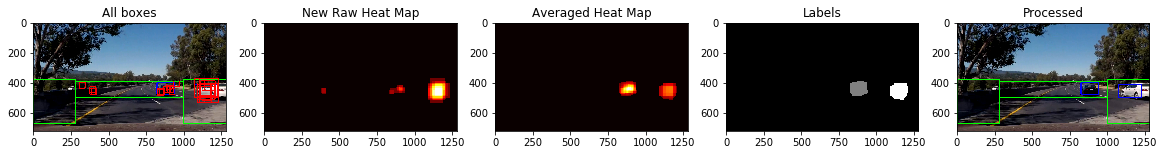

3.19 Seconds to process frame
car box windows found too high and removed
Fixed. Aspect: 0.6554621848739496 Height: 78 Width: 119 x: 879.5 y 441.0
Fixed. Aspect: 0.5555555555555556 Height: 85 Width: 153 x: 1146.5 y 456.5


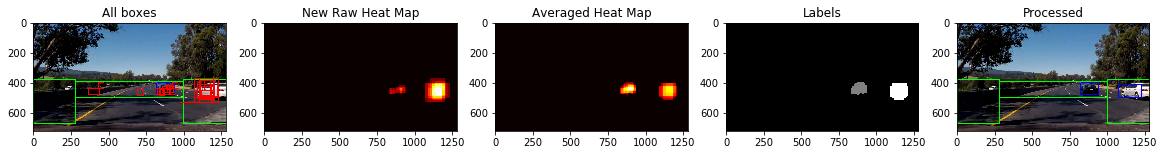

4.97 Seconds to process frame
Fixed. Aspect: 0.5555555555555556 Height: 85 Width: 153 x: 1146.5 y 456.5
Fixed. Aspect: 0.6638655462184874 Height: 79 Width: 119 x: 878.5 y 441.5


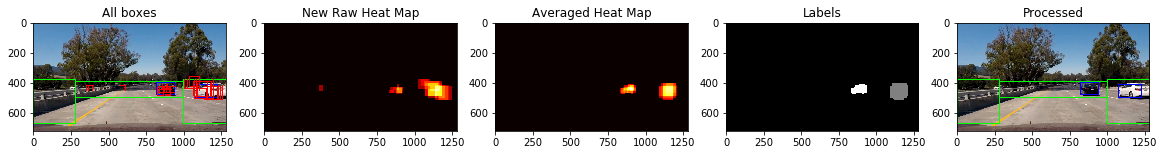

3.72 Seconds to process frame
Fixed. Aspect: 0.551948051948052 Height: 85 Width: 154 x: 1147.0 y 456.5
Fixed. Aspect: 0.6581196581196581 Height: 77 Width: 117 x: 878.5 y 440.5


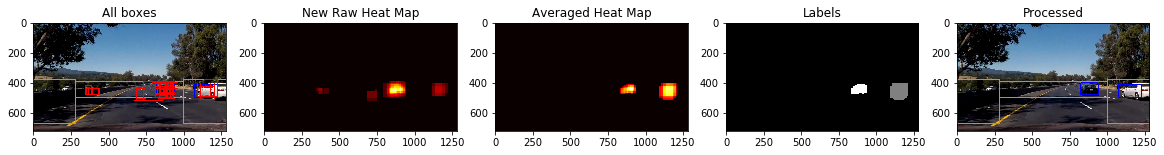

3.96 Seconds to process frame
Fixed. Aspect: 0.5454545454545454 Height: 84 Width: 154 x: 1154.0 y 455.0
Fixed. Aspect: 0.6694915254237288 Height: 79 Width: 118 x: 879.0 y 441.5


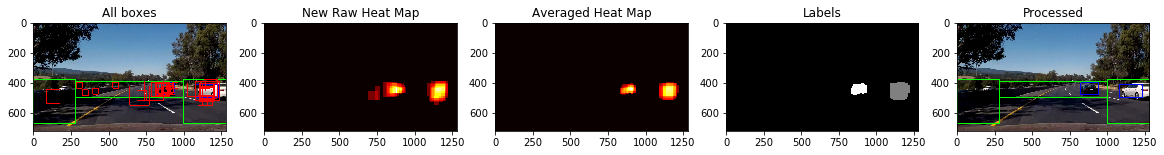

5.53 Seconds to process frame
Fixed. Aspect: 0.5555555555555556 Height: 85 Width: 153 x: 1153.5 y 455.5
Fixed. Aspect: 0.6583333333333333 Height: 79 Width: 120 x: 879.0 y 443.5


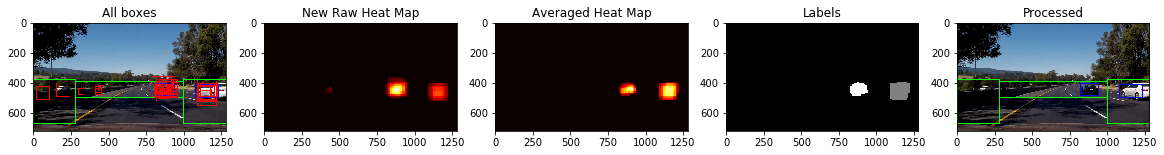

4.73 Seconds to process frame
Fixed. Aspect: 0.5562913907284768 Height: 84 Width: 151 x: 1153.5 y 453.0
Fixed. Aspect: 0.6639344262295082 Height: 81 Width: 122 x: 879.0 y 445.5


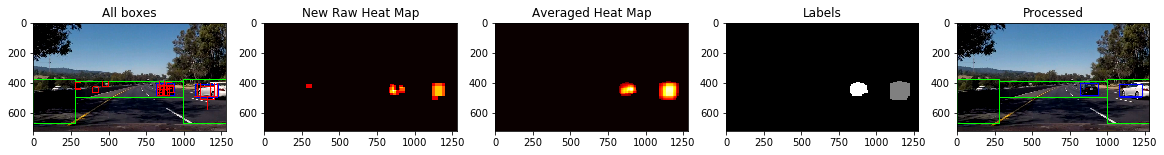

2.91 Seconds to process frame
Fixed. Aspect: 0.5562913907284768 Height: 84 Width: 151 x: 1149.5 y 453.0
Fixed. Aspect: 0.6694214876033058 Height: 81 Width: 121 x: 879.5 y 445.5


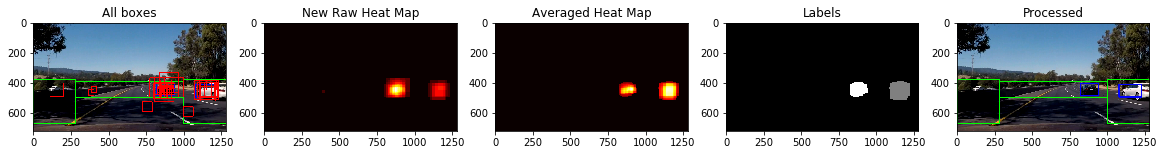

4.8 Seconds to process frame
Fixed. Aspect: 0.5460526315789473 Height: 83 Width: 152 x: 1154.0 y 452.5
Fixed. Aspect: 0.6639344262295082 Height: 81 Width: 122 x: 879.0 y 445.5


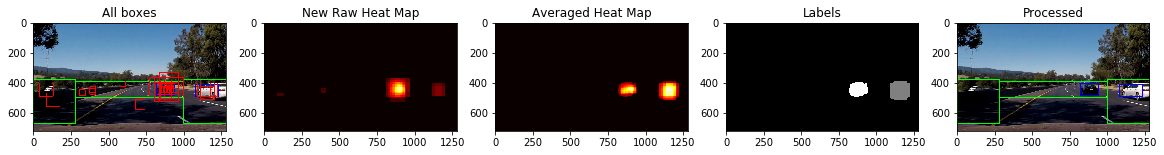

4.85 Seconds to process frame
Fixed. Aspect: 0.5526315789473685 Height: 84 Width: 152 x: 1154.0 y 453.0
Fixed. Aspect: 0.6638655462184874 Height: 79 Width: 119 x: 876.5 y 442.5


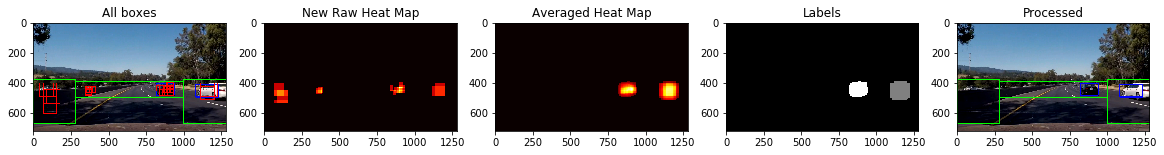

3.44 Seconds to process frame
Fixed. Aspect: 0.5526315789473685 Height: 84 Width: 152 x: 1154.0 y 454.0
Fixed. Aspect: 0.6666666666666666 Height: 80 Width: 120 x: 876.0 y 443.0


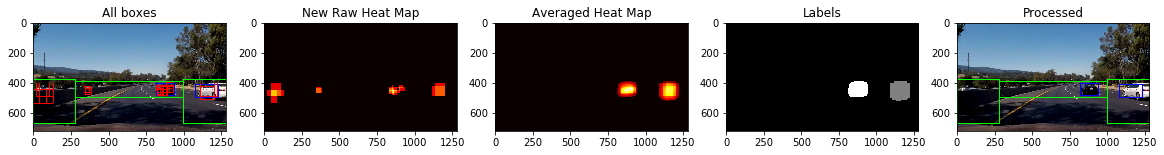

2.76 Seconds to process frame
Fixed. Aspect: 0.6637931034482759 Height: 77 Width: 116 x: 874.0 y 439.5
Fixed. Aspect: 0.5496688741721855 Height: 83 Width: 151 x: 1154.5 y 453.5


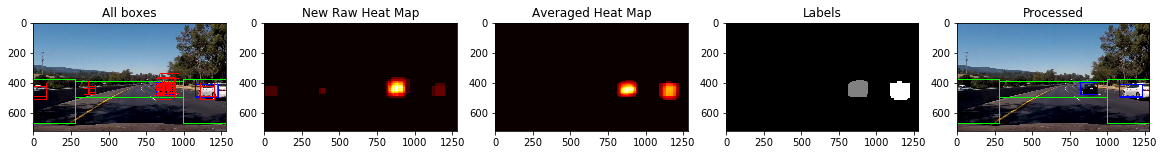

4.05 Seconds to process frame
Fixed. Aspect: 0.6551724137931034 Height: 76 Width: 116 x: 876.0 y 437.0
Fixed. Aspect: 0.5490196078431373 Height: 84 Width: 153 x: 1154.5 y 456.0


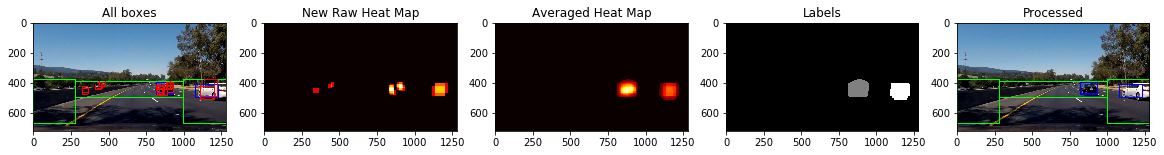

3.12 Seconds to process frame
Fixed. Aspect: 0.6578947368421053 Height: 75 Width: 114 x: 876.0 y 433.5
Fixed. Aspect: 0.551948051948052 Height: 85 Width: 154 x: 1156.0 y 456.5


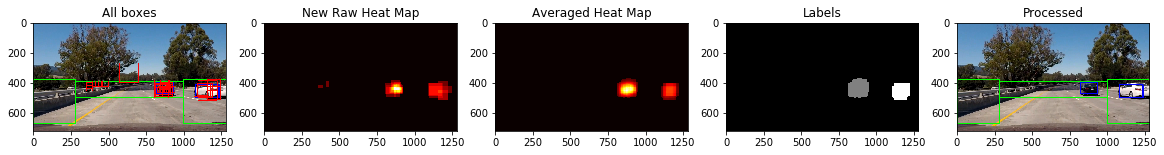

4.26 Seconds to process frame
car box windows found too high and removed
Fixed. Aspect: 0.6578947368421053 Height: 75 Width: 114 x: 878.0 y 433.5
Fixed. Aspect: 0.5483870967741935 Height: 85 Width: 155 x: 1158.5 y 456.5


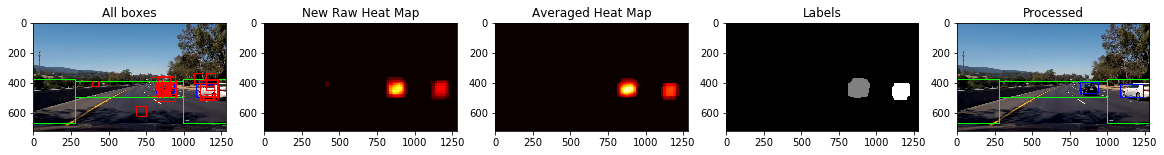

4.37 Seconds to process frame
Fixed. Aspect: 0.6637168141592921 Height: 75 Width: 113 x: 878.5 y 433.5
Fixed. Aspect: 0.5448717948717948 Height: 85 Width: 156 x: 1163.0 y 456.5


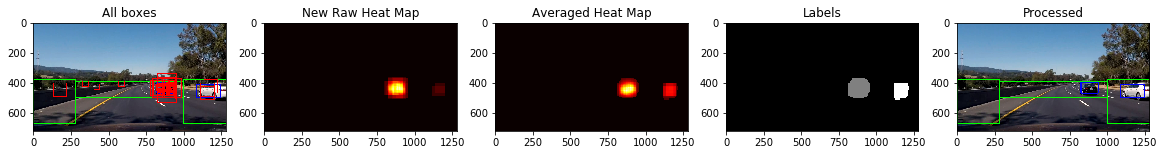

4.47 Seconds to process frame
Fixed. Aspect: 0.6578947368421053 Height: 75 Width: 114 x: 879.0 y 433.5
Fixed. Aspect: 0.5472972972972973 Height: 81 Width: 148 x: 1159.0 y 448.5
FAILED. Aspect: 2.25 Height: 18 Width: 8 x: 380.0 y 456.0
FAILED. Aspect: 0.210526315789 Height: 4 Width: 19 x: 1145.5 y 494.0


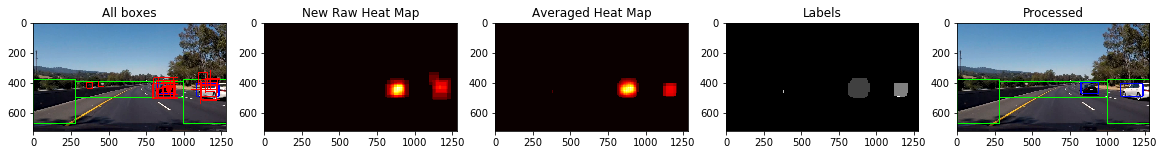

5.2 Seconds to process frame
Fixed. Aspect: 0.6637168141592921 Height: 75 Width: 113 x: 879.5 y 433.5
Fixed. Aspect: 0.5510204081632653 Height: 81 Width: 147 x: 1161.5 y 445.5
FAILED. Aspect: 3.375 Height: 27 Width: 8 x: 380.0 y 451.5


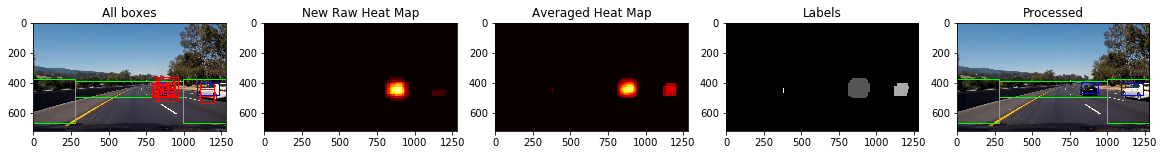

4.17 Seconds to process frame
Fixed. Aspect: 0.6666666666666666 Height: 76 Width: 114 x: 876.0 y 434.0
Fixed. Aspect: 0.5586206896551724 Height: 81 Width: 145 x: 1157.5 y 445.5
FAILED. Aspect: 2.25 Height: 18 Width: 8 x: 380.0 y 456.0


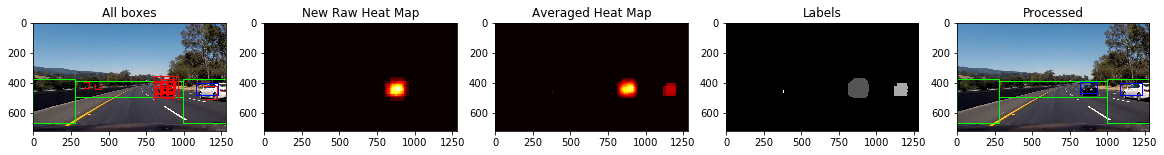

3.26 Seconds to process frame
Fixed. Aspect: 0.6608695652173913 Height: 76 Width: 115 x: 875.5 y 436.0
Fixed. Aspect: 0.5510204081632653 Height: 81 Width: 147 x: 1165.5 y 445.5


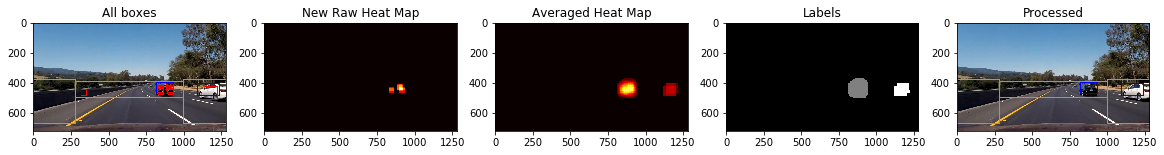

3.79 Seconds to process frame
Fixed. Aspect: 0.6666666666666666 Height: 76 Width: 114 x: 879.0 y 436.0
Fixed. Aspect: 0.5510204081632653 Height: 81 Width: 147 x: 1166.5 y 445.5


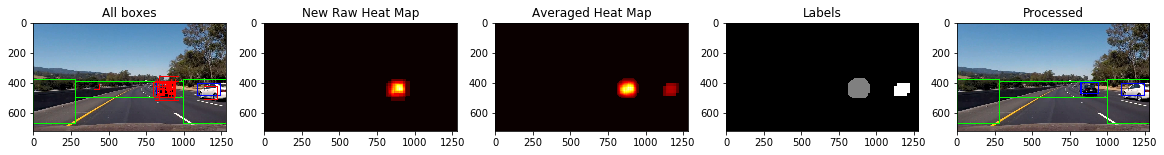

4.86 Seconds to process frame
car box windows found too high and removed
Fixed. Aspect: 0.6666666666666666 Height: 76 Width: 114 x: 879.0 y 434.0
Fixed. Aspect: 0.5517241379310345 Height: 80 Width: 145 x: 1166.5 y 443.0


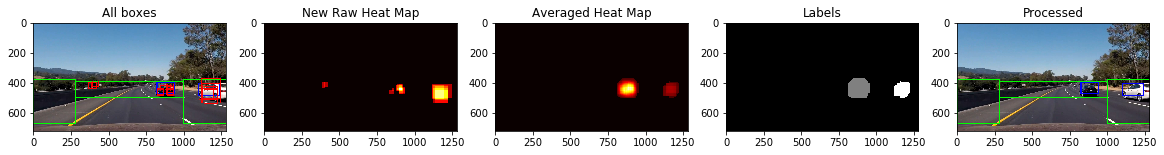

3.29 Seconds to process frame
Fixed. Aspect: 0.6608695652173913 Height: 76 Width: 115 x: 876.5 y 437.0
Fixed. Aspect: 0.5436241610738255 Height: 81 Width: 149 x: 1166.5 y 447.5


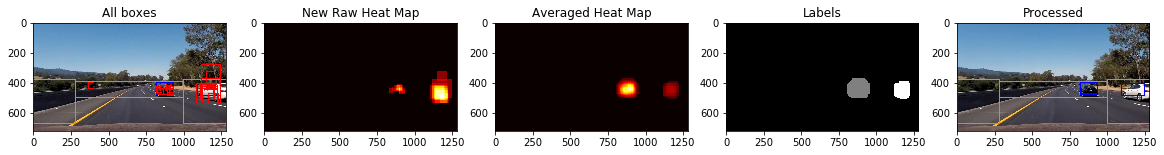

4.8 Seconds to process frame
Fixed. Aspect: 0.6666666666666666 Height: 76 Width: 114 x: 877.0 y 435.0
Fixed. Aspect: 0.5436241610738255 Height: 81 Width: 149 x: 1166.5 y 448.5


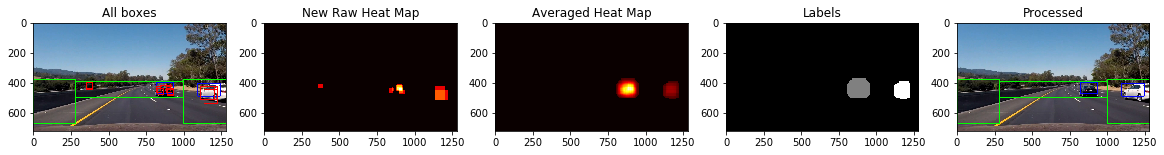

2.77 Seconds to process frame
Fixed. Aspect: 0.6666666666666666 Height: 76 Width: 114 x: 877.0 y 435.0
FAILED. Aspect: 0.111111111111 Height: 1 Width: 9 x: 1153.5 y 388.5
Fixed. Aspect: 0.543046357615894 Height: 82 Width: 151 x: 1168.5 y 452.0


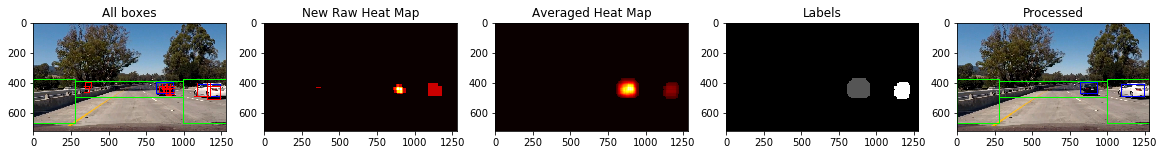

3.16 Seconds to process frame
Fixed. Aspect: 0.6724137931034483 Height: 78 Width: 116 x: 877.0 y 439.0
Fixed. Aspect: 0.5512820512820513 Height: 86 Width: 156 x: 1168.0 y 458.0


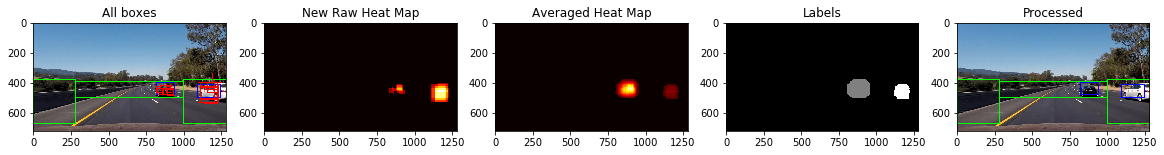

3.54 Seconds to process frame
car box windows found too high and removed
Fixed. Aspect: 0.6610169491525424 Height: 78 Width: 118 x: 876.0 y 441.0
Fixed. Aspect: 0.5443037974683544 Height: 86 Width: 158 x: 1169.0 y 460.0


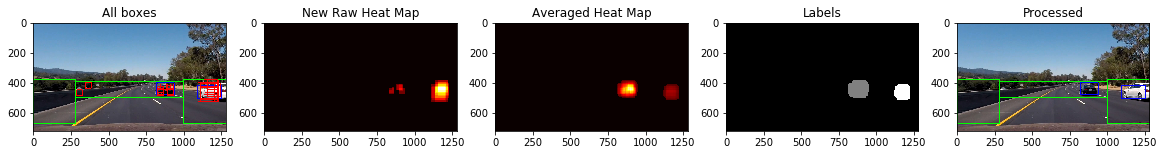

3.12 Seconds to process frame
car box windows found too high and removed
Fixed. Aspect: 0.6583333333333333 Height: 79 Width: 120 x: 874.0 y 443.5
Fixed. Aspect: 0.546583850931677 Height: 88 Width: 161 x: 1168.5 y 463.0


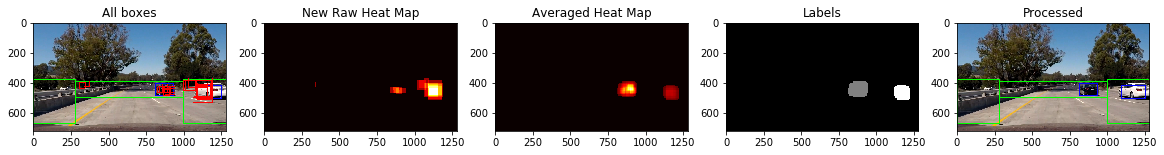

3.46 Seconds to process frame
Fixed. Aspect: 0.6581196581196581 Height: 77 Width: 117 x: 880.5 y 439.5
Fixed. Aspect: 0.5477707006369427 Height: 86 Width: 157 x: 1166.5 y 459.0


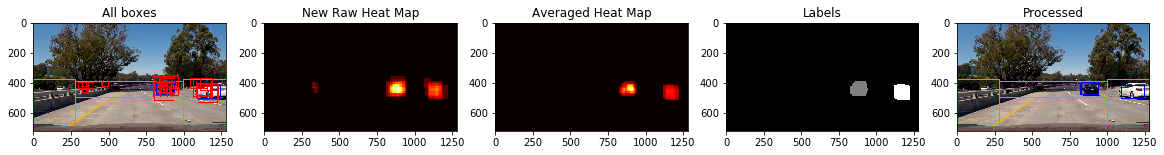

5.11 Seconds to process frame
Fixed. Aspect: 0.6608695652173913 Height: 76 Width: 115 x: 880.5 y 437.0
Fixed. Aspect: 0.5555555555555556 Height: 90 Width: 162 x: 1165.0 y 466.0


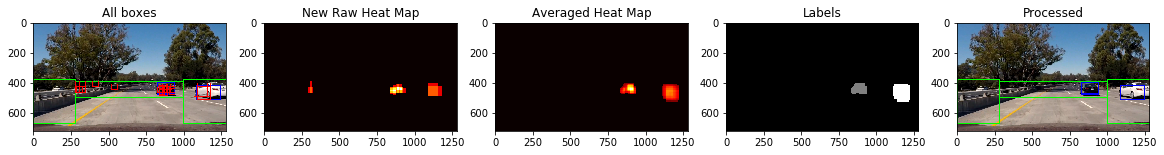

2.55 Seconds to process frame
Fixed. Aspect: 0.6608695652173913 Height: 76 Width: 115 x: 880.5 y 437.0
Fixed. Aspect: 0.5527950310559007 Height: 89 Width: 161 x: 1157.5 y 464.5


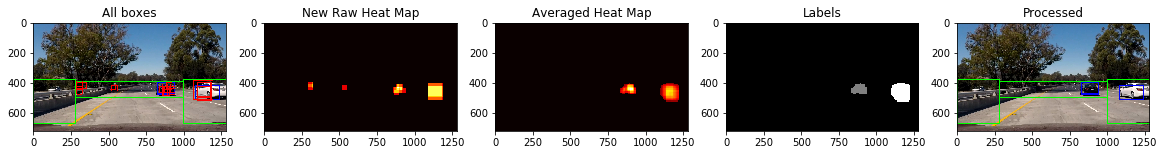

4.02 Seconds to process frame


In [92]:
%matplotlib inline
prev_bboxes = []
prev_heat_maps = []
car_centres = []


test_images = glob.glob('test_images/scene7/*.png')
i=0
for file in test_images:
    global i
    i +=1
    image = cv2.imread(file)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    t=time.time()
    processed_img, labels, av_heatmap, new_heatmap = process_video(image, debug_vis=True)
    t2=time.time()
    print(round(t2-t, 2), 'Seconds to process frame')


In [ ]:
car_pos_list = ([],[],[])#*len(car_centres)

for frame in range(0,len(car_centres)):
    l_max_cars=0
    # check if new frame has more cars than list can currently hold
    if len(car_centres[frame]) >= len(car_pos_list):
        car_pos_list.append([])
        print("car_pos_list:",car_pos_list)
        print("new length:", len(car_pos_list))
    for car in range(0,len(car_centres[frame])):
        l_max_cars+=1#print(car)
        print("car_centres[frame]:",car_centres[frame])
        print("car:",car)
        print("car_pos_list:",car_pos_list)
        new_car = (car_centres[frame][car][0],car_centres[frame][car][1],frame)
        print(len(new_car))
        print(len(car_pos_list))
        car_pos_list[0] = np.vstack((car_pos_list, new_car))
        #car_pos_list.append(new_car)
        
print(car_pos_list)

In [ ]:
# TODO: implement class for vehicles and lanes

class Vehicle_Detector():
    
    def __init__(self, n_fits=5):
        # how many frames should be collected for merging
        self.n_fits = n_fits
        # keep a list of previous bounding boxers
        self.prev_bboxes = []
        # the average heat map
        self.av_heat_map = None
        
    def update_heat_map(self, new_heat_map):
        self.av_heat_map = self.av_heat_map + 0.5 * new_heat_map
        
    def add_bbox(self, new_bbox):
        self.prev_bboxes.insert(0, new_bbox)
        # If the queue is full, remove the oldest
        if len(self.prev_bboxes)>self.n_fits:
            self.prev_bboxes.pop()
        
        
vd = Vehicle_Detector()


In [5]:
prev_bboxes = []
prev_heat_maps = []
car_centres = []

# process videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# video processing
video_output = 'output_videos/output_video24.mp4'
#clip = VideoFileClip("project_video.mp4")
clip = VideoFileClip('project_video.mp4')#.subclip(29,37)
video_clip = clip.fl_image(process_video)
%time video_clip.write_videofile(video_output, audio=False)
   

clip.reader.close()
video_clip.reader.close()
video_clip.audio.reader.close_proc()

[MoviePy] >>>> Building video output_videos/output_video22.mp4
[MoviePy] Writing video output_videos/output_video22.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [41:24<00:02,  2.19s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/output_video22.mp4 

Wall time: 41min 26s


In [ ]:
# in case the video above crashes you can run this to close the video handle
clip.reader.close()
video_clip.reader.close()
video_clip.audio.reader.close_proc()

### Helper function to clip a section of a video and capture screen shots


In [ ]:
import cv2
import os
import matplotlib.pyplot as plt

directory = 'test_images/scene7/'
filename = 'test_images/scene7/scene'
i = 0

def clip_and_split(img):
    plt.imshow(img)
    plt.show()
        
    global i
    if os.path.isdir(directory):
        print("Path exists")
        i += 1
        img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        cv2.imwrite('{}{:d}.png'.format(filename, i), img_bgr)
        print("Image saved", i)
    
    return img

# process videos
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# video processing

#clip = VideoFileClip("project_video.mp4")
video_output = 'test_images/scene7/scene.mp4'
clip = VideoFileClip('project_video.mp4').subclip(40.5,42.5)
video_clip = clip.fl_image(clip_and_split)
%time video_clip.write_videofile(video_output, audio=False)

clip.reader.close()
video_clip.reader.close()
video_clip.audio.reader.close_proc()